In [3]:
#import all the necessary packages.

from PIL import Image
import requests
from io import BytesIO
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import warnings
from bs4 import BeautifulSoup
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import nltk
import math
import time
import re
import os
import seaborn as sns
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity  
from sklearn.metrics import pairwise_distances
from matplotlib import gridspec
from scipy.sparse import hstack
import plotly
import plotly.figure_factory as ff
from plotly.graph_objs import Scatter, Layout

plotly.offline.init_notebook_mode(connected=True)
warnings.filterwarnings("ignore")

In [4]:
data = pd.read_pickle('pickels/16k_apperal_data_preprocessed')
data.head()

asin                        brand              color  \
4   B004GSI2OS                  FeatherLite  Onyx Black/ Stone   
6   B012YX2ZPI  HX-Kingdom Fashion T-shirts              White   
15  B003BSRPB0                  FeatherLite              White   
27  B014ICEJ1Q                        FNC7C             Purple   
46  B01NACPBG2                 Fifth Degree              Black   

                                     medium_image_url product_type_name  \
4   https://images-na.ssl-images-amazon.com/images...             SHIRT   
6   https://images-na.ssl-images-amazon.com/images...             SHIRT   
15  https://images-na.ssl-images-amazon.com/images...             SHIRT   
27  https://images-na.ssl-images-amazon.com/images...             SHIRT   
46  https://images-na.ssl-images-amazon.com/images...             SHIRT   

                                                title formatted_price  
4   featherlite ladies long sleeve stain resistant...          $26.26  
6   womens unique 100 cotton  special olympics wor...           $9.99  
15  featherlite ladies moisture free mesh sport sh...          $20.54  
27  supernatural chibis sam dean castiel neck tshi...           $7.39  
46  fifth degree womens gold foil graphic tees jun...           $6.95

In [5]:
# Utility Functions which we will use through the rest of the workshop.


#Display an image
def display_img(url,ax,fig):
    # we get the url of the apparel and download it
    response = requests.get(url)
    img = Image.open(BytesIO(response.content))
    # we will display it in notebook 
    plt.imshow(img)
  
#plotting code to understand the algorithm's decision.
def plot_heatmap(keys, values, labels, url, text):
        # keys: list of words of recommended title
        # values: len(values) ==  len(keys), values(i) represents the occurence of the word keys(i)
        # labels: len(labels) == len(keys), the values of labels depends on the model we are using
                # if model == 'bag of words': labels(i) = values(i)
                # if model == 'tfidf weighted bag of words':labels(i) = tfidf(keys(i))
                # if model == 'idf weighted bag of words':labels(i) = idf(keys(i))
        # url : apparel's url

        # we will devide the whole figure into two parts
        gs = gridspec.GridSpec(2, 2, width_ratios=[4,1], height_ratios=[4,1]) 
        fig = plt.figure(figsize=(25,3))
        
        # 1st, ploting heat map that represents the count of commonly ocurred words in title2
        ax = plt.subplot(gs[0])
        # it displays a cell in white color if the word is intersection(lis of words of title1 and list of words of title2), in black if not
        ax = sns.heatmap(np.array([values]), annot=np.array([labels]))
        ax.set_xticklabels(keys) # set that axis labels as the words of title
        ax.set_title(text) # apparel title
        
        # 2nd, plotting image of the the apparel
        ax = plt.subplot(gs[1])
        # we don't want any grid lines for image and no labels on x-axis and y-axis
        ax.grid(False)
        ax.set_xticks([])
        ax.set_yticks([])
        
        # we call dispaly_img based with paramete url
        display_img(url, ax, fig)
        
        # displays combine figure ( heat map and image together)
        plt.show()
    
def plot_heatmap_image(doc_id, vec1, vec2, url, text, model):

    # doc_id : index of the title1
    # vec1 : input apparels's vector, it is of a dict type {word:count}
    # vec2 : recommended apparels's vector, it is of a dict type {word:count}
    # url : apparels image url
    # text: title of recomonded apparel (used to keep title of image)
    # model, it can be any of the models, 
        # 1. bag_of_words
        # 2. tfidf
        # 3. idf

    # we find the common words in both titles, because these only words contribute to the distance between two title vec's
    intersection = set(vec1.keys()) & set(vec2.keys()) 

    # we set the values of non intersecting words to zero, this is just to show the difference in heatmap
    for i in vec2:
        if i not in intersection:
            vec2[i]=0

    # for labeling heatmap, keys contains list of all words in title2
    keys = list(vec2.keys())
    #  if ith word in intersection(lis of words of title1 and list of words of title2): values(i)=count of that word in title2 else values(i)=0 
    values = [vec2[x] for x in vec2.keys()]
    
    # labels: len(labels) == len(keys), the values of labels depends on the model we are using
        # if model == 'bag of words': labels(i) = values(i)
        # if model == 'tfidf weighted bag of words':labels(i) = tfidf(keys(i))
        # if model == 'idf weighted bag of words':labels(i) = idf(keys(i))

    if model == 'bag_of_words':
        labels = values
    elif model == 'tfidf':
        labels = []
        for x in vec2.keys():
            # tfidf_title_vectorizer.vocabulary_ it contains all the words in the corpus
            # tfidf_title_features[doc_id, index_of_word_in_corpus] will give the tfidf value of word in given document (doc_id)
            if x in  tfidf_title_vectorizer.vocabulary_:
                labels.append(tfidf_title_features[doc_id, tfidf_title_vectorizer.vocabulary_[x]])
            else:
                labels.append(0)
    elif model == 'idf':
        labels = []
        for x in vec2.keys():
            # idf_title_vectorizer.vocabulary_ it contains all the words in the corpus
            # idf_title_features[doc_id, index_of_word_in_corpus] will give the idf value of word in given document (doc_id)
            if x in  idf_title_vectorizer.vocabulary_:
                labels.append(idf_title_features[doc_id, idf_title_vectorizer.vocabulary_[x]])
            else:
                labels.append(0)

    plot_heatmap(keys, values, labels, url, text)


# this function gets a list of wrods along with the frequency of each 
# word given "text"
def text_to_vector(text):
    word = re.compile(r'\w+')
    words = word.findall(text)
    # words stores list of all words in given string, you can try 'words = text.split()' this will also gives same result
    return Counter(words) # Counter counts the occurence of each word in list, it returns dict type object {word1:count}



def get_result(doc_id, content_a, content_b, url, model):
    text1 = content_a
    text2 = content_b
    
    # vector1 = dict{word11:#count, word12:#count, etc.}
    vector1 = text_to_vector(text1)

    # vector1 = dict{word21:#count, word22:#count, etc.}
    vector2 = text_to_vector(text2)

    plot_heatmap_image(doc_id, vector1, vector2, url, text2, model)

In [6]:
from sklearn.feature_extraction.text import CountVectorizer
title_vectorizer = CountVectorizer()
title_features   = title_vectorizer.fit_transform(data['title'])
title_features.get_shape() # get number of rows and columns in feature matrix.
# title_features.shape = #data_points * #words_in_corpus
# CountVectorizer().fit_transform(corpus) returns 
# the a sparase matrix of dimensions #data_points * #words_in_corpus

# What is a sparse vector?

# title_features[doc_id, index_of_word_in_corpus] = number of times the word occured in that doc

(16042, 12609)

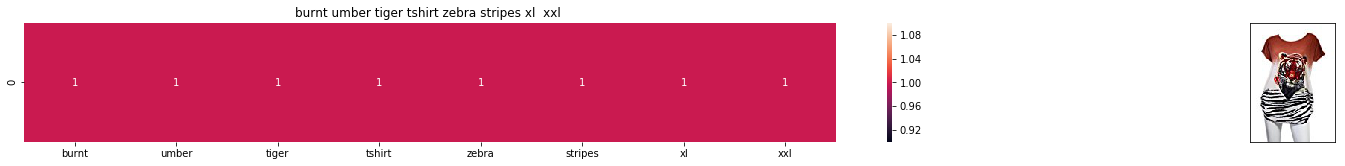

ASIN : B00JXQB5FQ
Brand: Si Row
Title: burnt umber tiger tshirt zebra stripes xl  xxl 
Euclidean similarity with the query image : 0.0


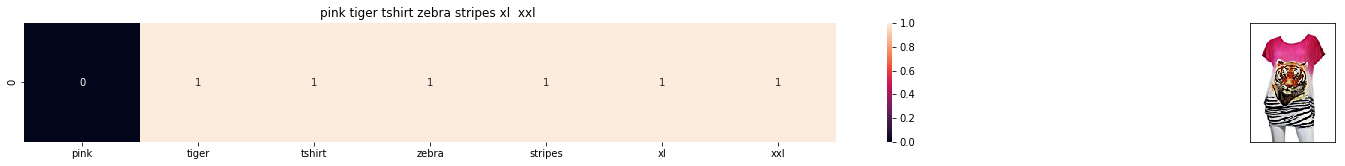

ASIN : B00JXQASS6
Brand: Si Row
Title: pink tiger tshirt zebra stripes xl  xxl 
Euclidean similarity with the query image : 1.73205080757


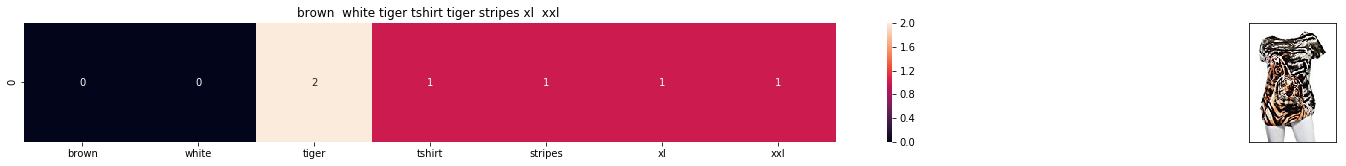

ASIN : B00JXQCWTO
Brand: Si Row
Title: brown  white tiger tshirt tiger stripes xl  xxl 
Euclidean similarity with the query image : 2.44948974278


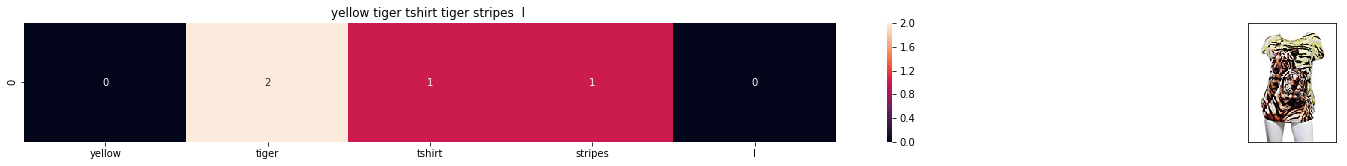

ASIN : B00JXQCUIC
Brand: Si Row
Title: yellow tiger tshirt tiger stripes  l 
Euclidean similarity with the query image : 2.64575131106


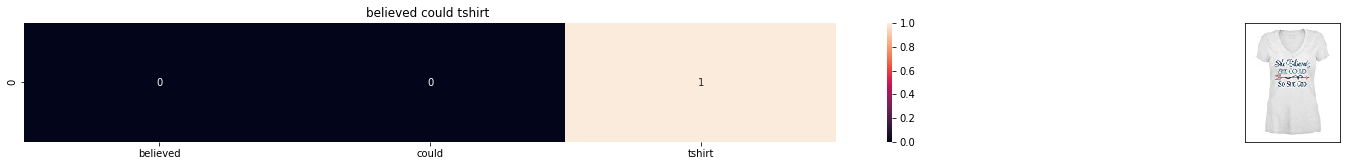

ASIN : B07568NZX4
Brand: Rustic Grace
Title: believed could tshirt 
Euclidean similarity with the query image : 3.0


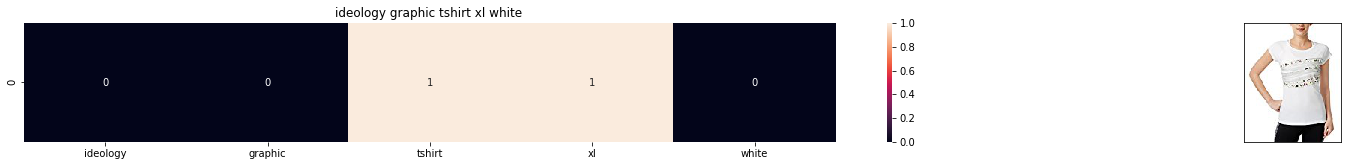

ASIN : B01NB0NKRO
Brand: Ideology
Title: ideology graphic tshirt xl white 
Euclidean similarity with the query image : 3.0


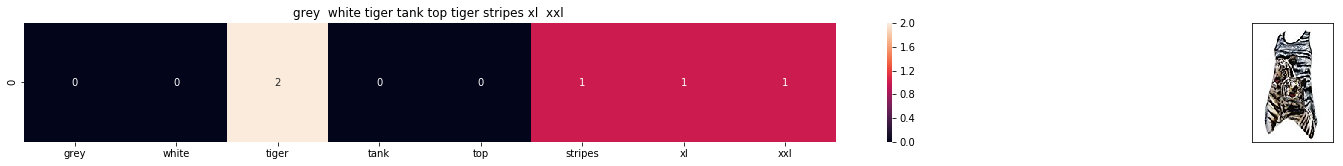

ASIN : B00JXQAFZ2
Brand: Si Row
Title: grey  white tiger tank top tiger stripes xl  xxl 
Euclidean similarity with the query image : 3.0


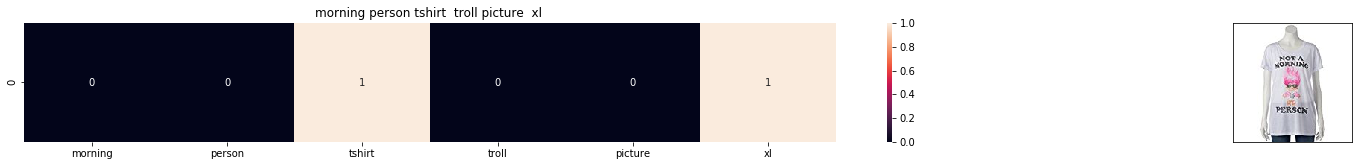

ASIN : B01CLS8LMW
Brand: Awake
Title: morning person tshirt  troll picture  xl 
Euclidean similarity with the query image : 3.16227766017


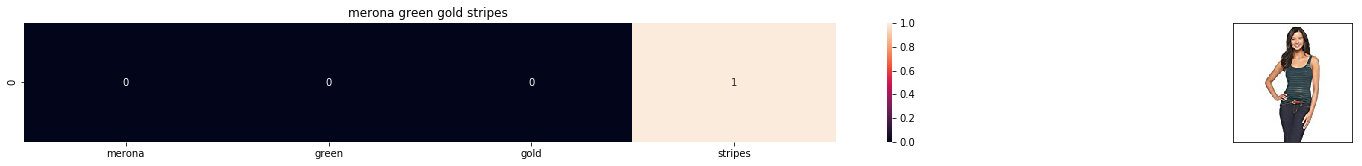

ASIN : B01KVZUB6G
Brand: Merona
Title: merona green gold stripes 
Euclidean similarity with the query image : 3.16227766017


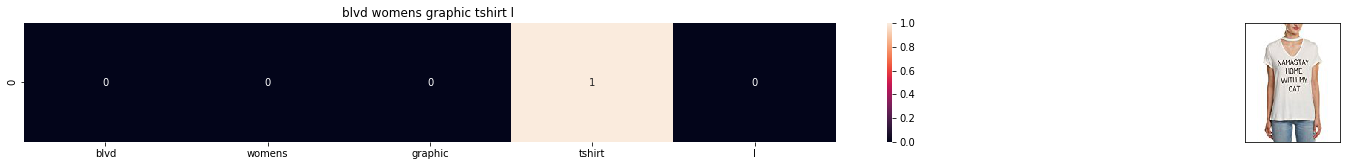

ASIN : B0733R2CJK
Brand: BLVD
Title: blvd womens graphic tshirt l 
Euclidean similarity with the query image : 3.16227766017


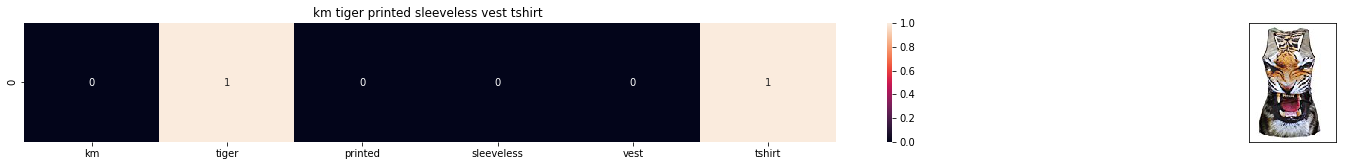

ASIN : B012VQLT6Y
Brand: KM T-shirt
Title: km tiger printed sleeveless vest tshirt 
Euclidean similarity with the query image : 3.16227766017


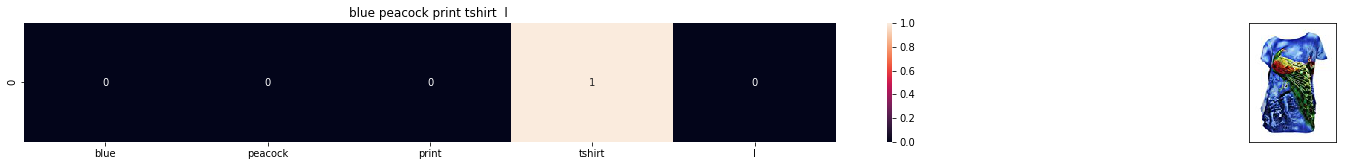

ASIN : B00JXQC8L6
Brand: Si Row
Title: blue peacock print tshirt  l 
Euclidean similarity with the query image : 3.16227766017


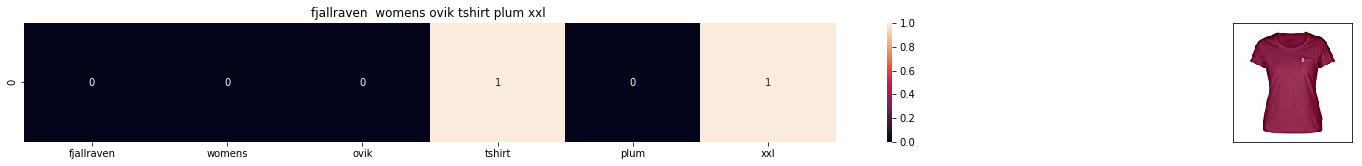

ASIN : B06XC3CZF6
Brand: Fjallraven
Title: fjallraven  womens ovik tshirt plum xxl 
Euclidean similarity with the query image : 3.16227766017


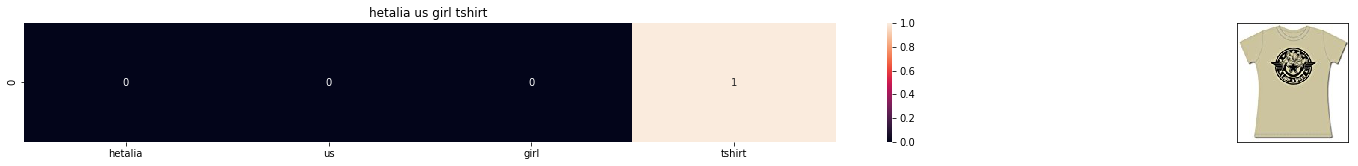

ASIN : B005IT8OBA
Brand: Hetalia
Title: hetalia us girl tshirt 
Euclidean similarity with the query image : 3.16227766017


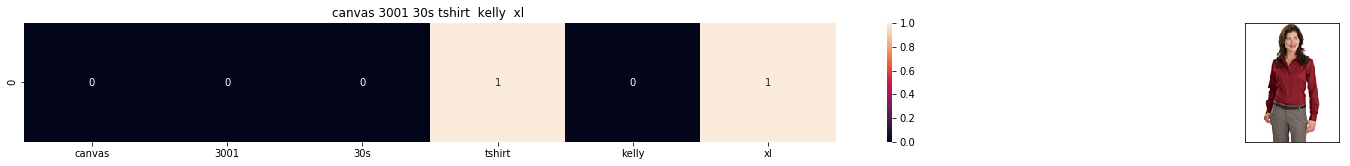

ASIN : B0088PN0LA
Brand: Red House
Title: canvas 3001 30s tshirt  kelly  xl 
Euclidean similarity with the query image : 3.16227766017


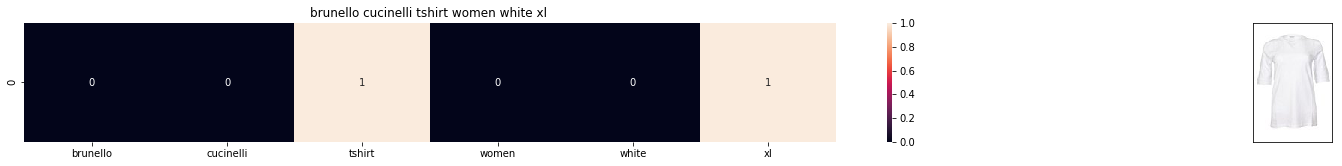

ASIN : B06X99V6WC
Brand: Brunello Cucinelli
Title: brunello cucinelli tshirt women white xl 
Euclidean similarity with the query image : 3.16227766017


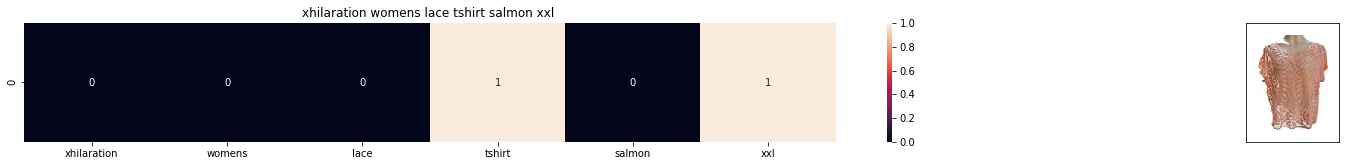

ASIN : B06Y1JPW1Q
Brand: Xhilaration
Title: xhilaration womens lace tshirt salmon xxl 
Euclidean similarity with the query image : 3.16227766017


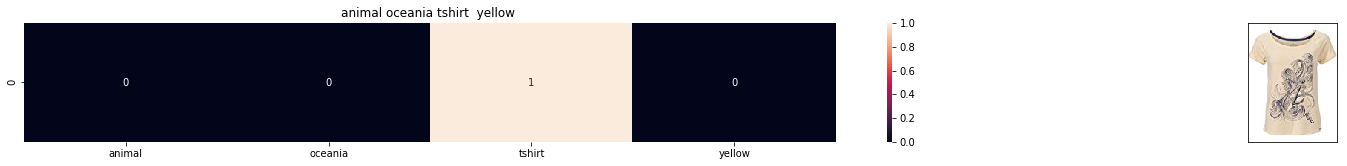

ASIN : B06X6GX6WG
Brand: Animal
Title: animal oceania tshirt  yellow 
Euclidean similarity with the query image : 3.16227766017


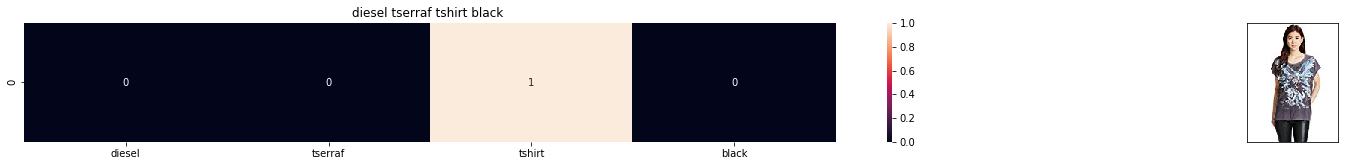

ASIN : B017X8PW9U
Brand: Diesel
Title: diesel tserraf tshirt black 
Euclidean similarity with the query image : 3.16227766017


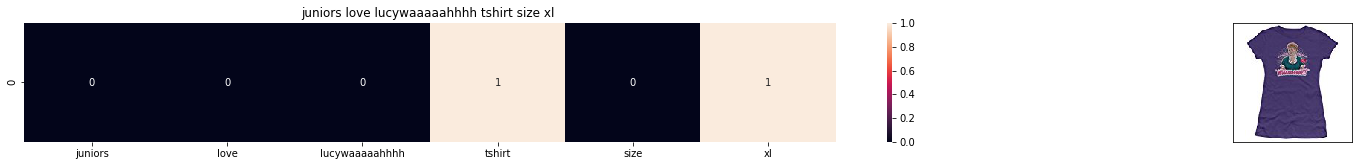

ASIN : B00IAA4JIQ
Brand: I Love Lucy
Title: juniors love lucywaaaaahhhh tshirt size xl 
Euclidean similarity with the query image : 3.16227766017


In [7]:
def bag_of_words_model(doc_id, num_results):
    # doc_id: apparel's id in given corpus
    
    # pairwise_dist will store the distance from given input apparel to all remaining apparels
    # the metric we used here is cosine, the coside distance is mesured as K(X, Y) = <X, Y> / (||X||*||Y||)
    # http://scikit-learn.org/stable/modules/metrics.html#cosine-similarity
    pairwise_dist = pairwise_distances(title_features,title_features[doc_id])
    
    # np.argsort will return indices of the smallest distances
    indices = np.argsort(pairwise_dist.flatten())[0:num_results]
    #pdists will store the smallest distances
    pdists  = np.sort(pairwise_dist.flatten())[0:num_results]

    #data frame indices of the 9 smallest distace's
    df_indices = list(data.index[indices])
    
    for i in range(0,len(indices)):
        # we will pass 1. doc_id, 2. title1, 3. title2, url, model
        get_result(indices[i],data['title'].loc[df_indices[0]], data['title'].loc[df_indices[i]], data['medium_image_url'].loc[df_indices[i]], 'bag_of_words')
        print('ASIN :',data['asin'].loc[df_indices[i]])
        print ('Brand:', data['brand'].loc[df_indices[i]])
        print ('Title:', data['title'].loc[df_indices[i]])
        print ('Euclidean similarity with the query image :', pdists[i])
        print('='*60)

#call the bag-of-words model for a product to get similar products.
bag_of_words_model(12566, 20) # change the index if you want to.
# In the output heat map each value represents the count value 
# of the label word, the color represents the intersection 
# with inputs title.

#try 12566
#try 931

In [8]:
tfidf_title_vectorizer = TfidfVectorizer(min_df = 0)
tfidf_title_features = tfidf_title_vectorizer.fit_transform(data['title'])

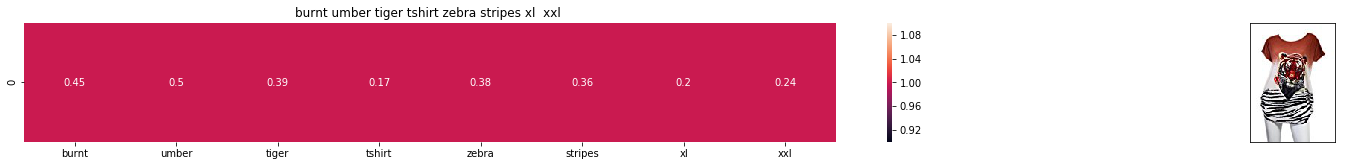

ASIN : B00JXQB5FQ
BRAND : Si Row
Eucliden distance from the given image : 0.0


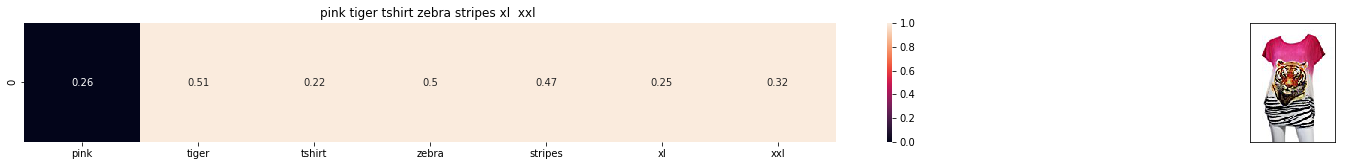

ASIN : B00JXQASS6
BRAND : Si Row
Eucliden distance from the given image : 0.753633191245


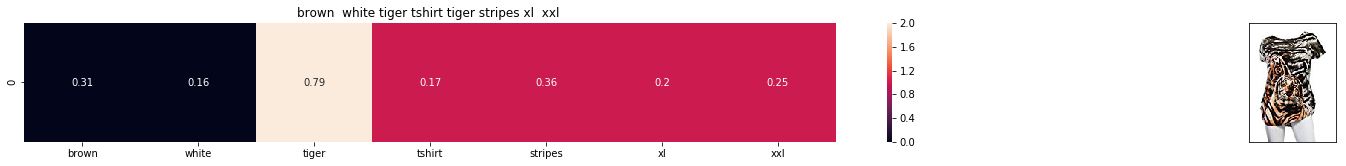

ASIN : B00JXQCWTO
BRAND : Si Row
Eucliden distance from the given image : 0.935764394377


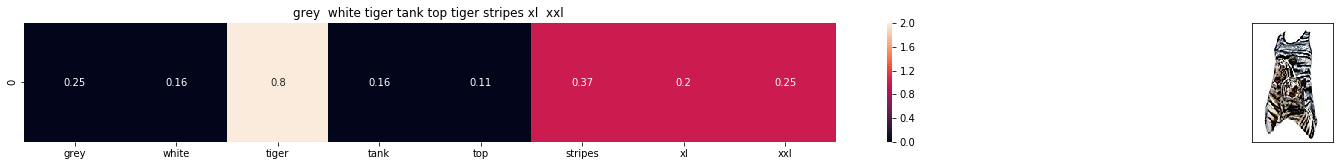

ASIN : B00JXQAFZ2
BRAND : Si Row
Eucliden distance from the given image : 0.95861535242


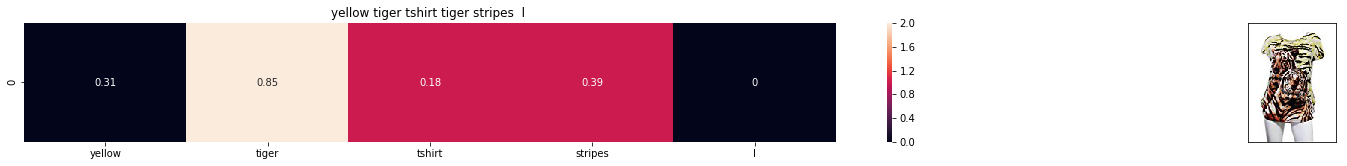

ASIN : B00JXQCUIC
BRAND : Si Row
Eucliden distance from the given image : 1.00007496145


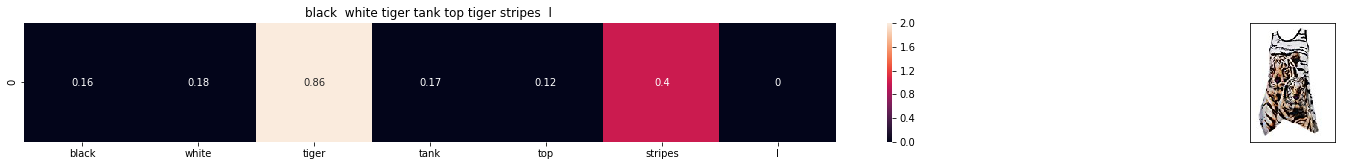

ASIN : B00JXQAO94
BRAND : Si Row
Eucliden distance from the given image : 1.02321555246


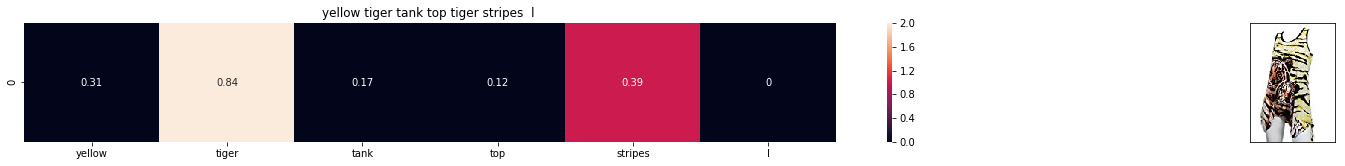

ASIN : B00JXQAUWA
BRAND : Si Row
Eucliden distance from the given image : 1.0319918463


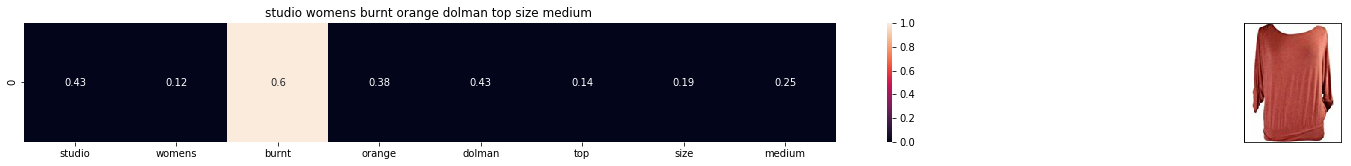

ASIN : B06XSCVFT5
BRAND : Studio M
Eucliden distance from the given image : 1.21068436704


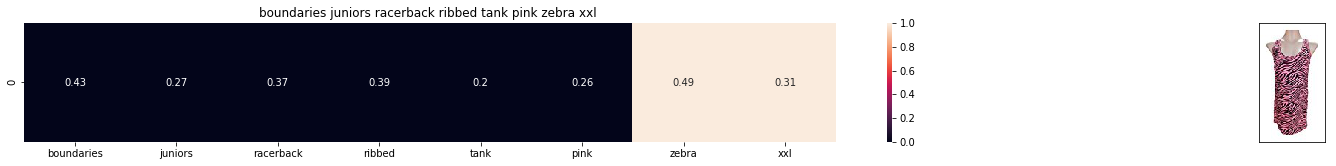

ASIN : B06Y2GTYPM
BRAND : No Boundaries
Eucliden distance from the given image : 1.21216838107


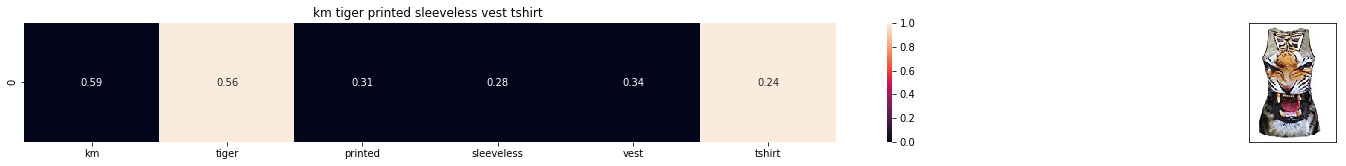

ASIN : B012VQLT6Y
BRAND : KM T-shirt
Eucliden distance from the given image : 1.21979064028


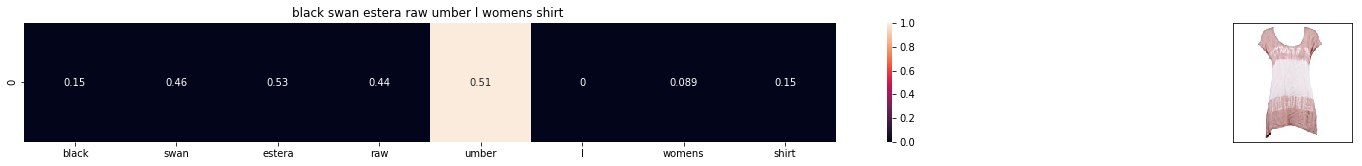

ASIN : B06Y1VN8WQ
BRAND : Black Swan
Eucliden distance from the given image : 1.220684966


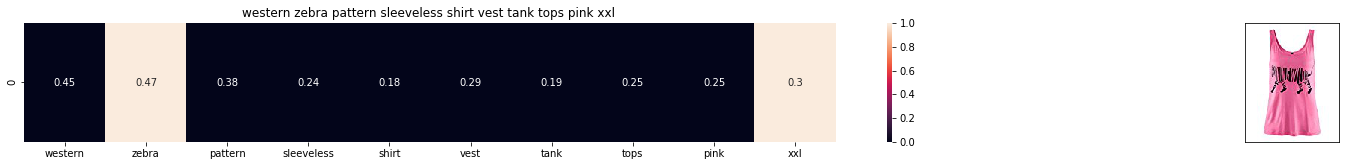

ASIN : B00Z6HEXWI
BRAND : Black Temptation
Eucliden distance from the given image : 1.22128139212


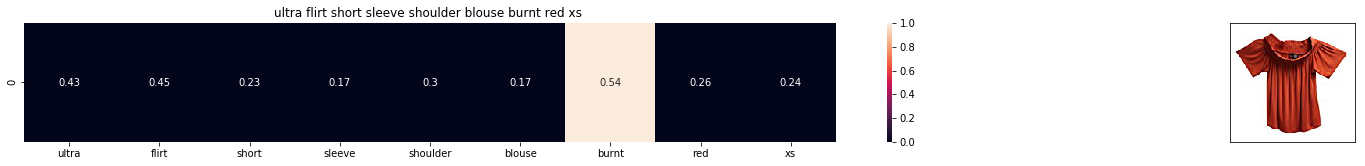

ASIN : B074TR12BH
BRAND : Ultra Flirt
Eucliden distance from the given image : 1.23133640946


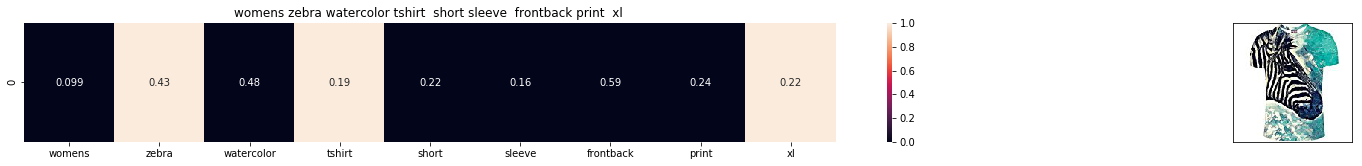

ASIN : B072R2JXKW
BRAND : WHAT ON EARTH
Eucliden distance from the given image : 1.23184519726


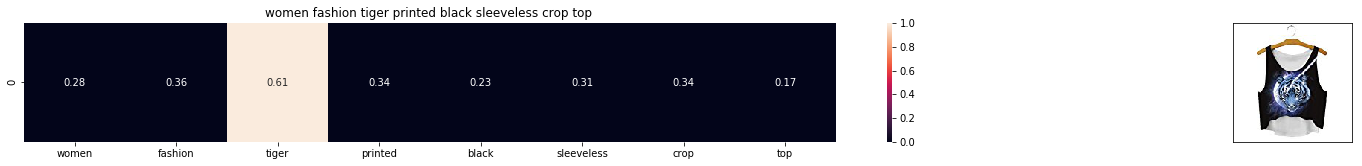

ASIN : B074T8ZYGX
BRAND : MKP Crop Top
Eucliden distance from the given image : 1.23406074574


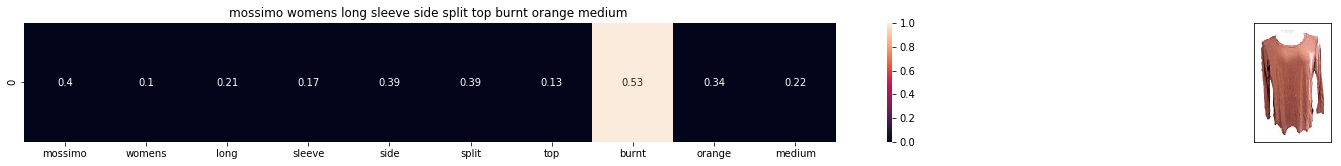

ASIN : B071ZDF6T2
BRAND : Mossimo
Eucliden distance from the given image : 1.23527855777


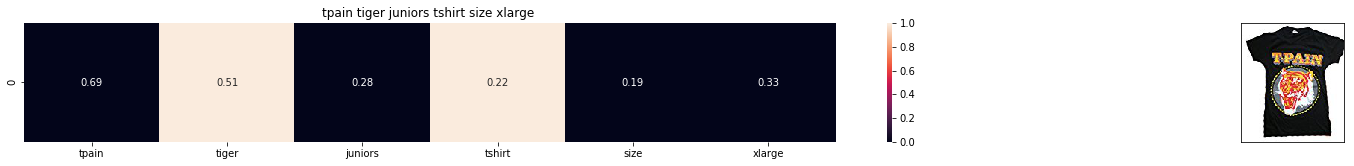

ASIN : B01K0H02OG
BRAND : Tultex
Eucliden distance from the given image : 1.23645729881


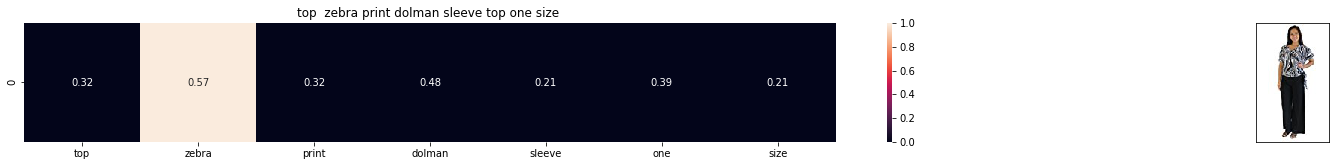

ASIN : B00H8A6ZLI
BRAND : Vivian's Fashions
Eucliden distance from the given image : 1.24996155053


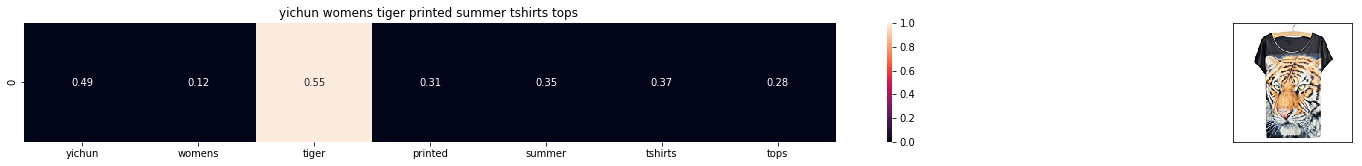

ASIN : B010NN9RXO
BRAND : YICHUN
Eucliden distance from the given image : 1.25354614209


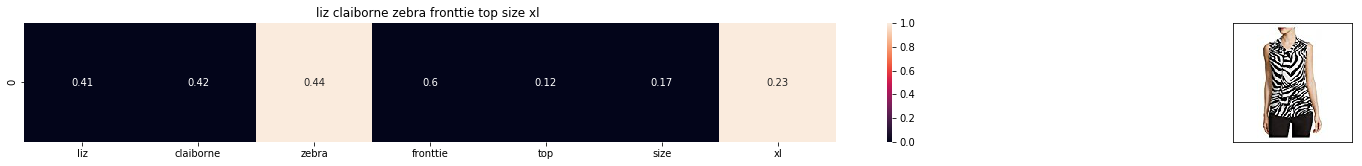

ASIN : B06XBY5QXL
BRAND : Liz Claiborne
Eucliden distance from the given image : 1.25388329384


In [9]:
def tfidf_model(doc_id, num_results):
    # doc_id: apparel's id in given corpus
    
    # pairwise_dist will store the distance from given input apparel to all remaining apparels
    # the metric we used here is cosine, the coside distance is mesured as K(X, Y) = <X, Y> / (||X||*||Y||)
    # http://scikit-learn.org/stable/modules/metrics.html#cosine-similarity
    pairwise_dist = pairwise_distances(tfidf_title_features,tfidf_title_features[doc_id])

    # np.argsort will return indices of 9 smallest distances
    indices = np.argsort(pairwise_dist.flatten())[0:num_results]
    #pdists will store the 9 smallest distances
    pdists  = np.sort(pairwise_dist.flatten())[0:num_results]

    #data frame indices of the 9 smallest distace's
    df_indices = list(data.index[indices])

    for i in range(0,len(indices)):
        # we will pass 1. doc_id, 2. title1, 3. title2, url, model
        get_result(indices[i], data['title'].loc[df_indices[0]], data['title'].loc[df_indices[i]], data['medium_image_url'].loc[df_indices[i]], 'tfidf')
        print('ASIN :',data['asin'].loc[df_indices[i]])
        print('BRAND :',data['brand'].loc[df_indices[i]])
        print ('Eucliden distance from the given image :', pdists[i])
        print('='*125)
tfidf_model(12566, 20)
# in the output heat map each value represents the tfidf values of the label word, the color represents the intersection with inputs title

In [10]:
idf_title_vectorizer = CountVectorizer()
idf_title_features = idf_title_vectorizer.fit_transform(data['title'])

# idf_title_features.shape = #data_points * #words_in_corpus
# CountVectorizer().fit_transform(courpus) returns the a sparase matrix of dimensions #data_points * #words_in_corpus
# idf_title_features[doc_id, index_of_word_in_corpus] = number of times the word occured in that doc

In [11]:
def n_containing(word):
    # return the number of documents which had the given word
    return sum(1 for blob in data['title'] if word in blob.split())

def idf(word):
    # idf = log(#number of docs / #number of docs which had the given word)
    return math.log(data.shape[0] / (n_containing(word)))

In [12]:
# we need to convert the values into float
idf_title_features  = idf_title_features.astype(np.float)

for i in idf_title_vectorizer.vocabulary_.keys():
    # for every word in whole corpus we will find its idf value
    idf_val = idf(i)
    
    # to calculate idf_title_features we need to replace the count values with the idf values of the word
    # idf_title_features[:, idf_title_vectorizer.vocabulary_[i]].nonzero()[0] will return all documents in which the word i present
    for j in idf_title_features[:, idf_title_vectorizer.vocabulary_[i]].nonzero()[0]:
        
        # we replace the count values of word i in document j with  idf_value of word i 
        # idf_title_features[doc_id, index_of_word_in_courpus] = idf value of word
        idf_title_features[j,idf_title_vectorizer.vocabulary_[i]] = idf_val
        

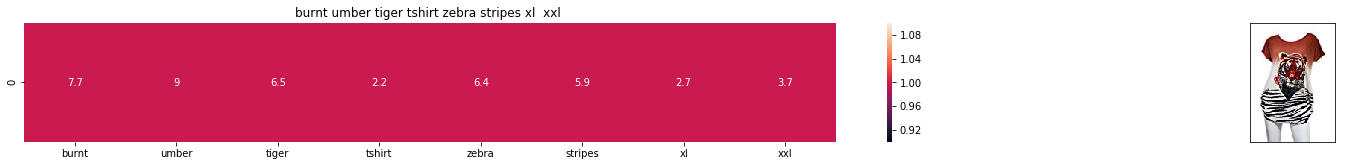

ASIN : B00JXQB5FQ
Brand : Si Row
euclidean distance from the given image : 0.0


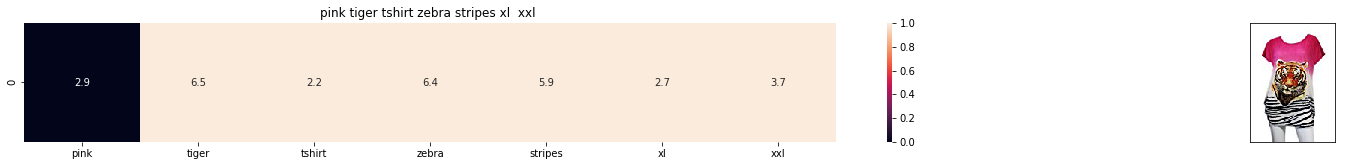

ASIN : B00JXQASS6
Brand : Si Row
euclidean distance from the given image : 12.2050713112


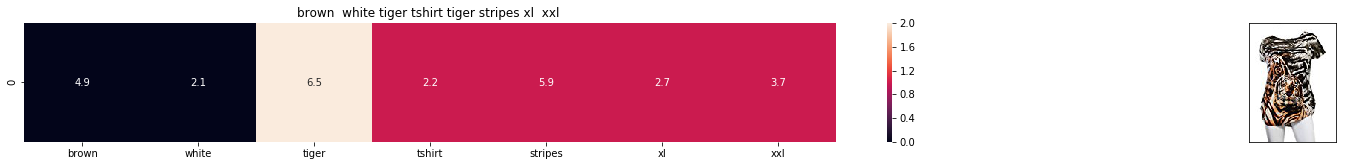

ASIN : B00JXQCWTO
Brand : Si Row
euclidean distance from the given image : 14.4683626856


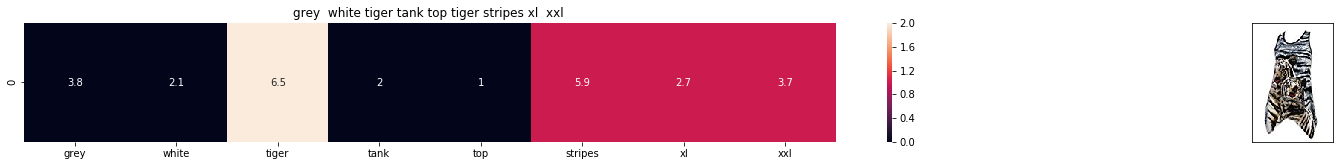

ASIN : B00JXQAFZ2
Brand : Si Row
euclidean distance from the given image : 14.4868329248


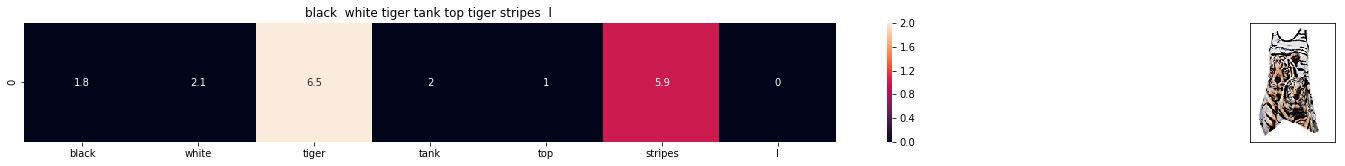

ASIN : B00JXQAO94
Brand : Si Row
euclidean distance from the given image : 14.8333929667


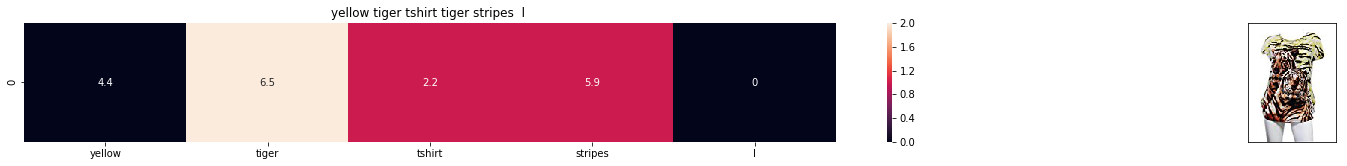

ASIN : B00JXQCUIC
Brand : Si Row
euclidean distance from the given image : 14.8987445167


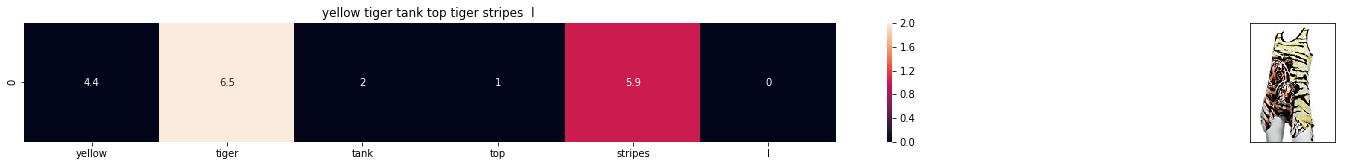

ASIN : B00JXQAUWA
Brand : Si Row
euclidean distance from the given image : 15.2244582873


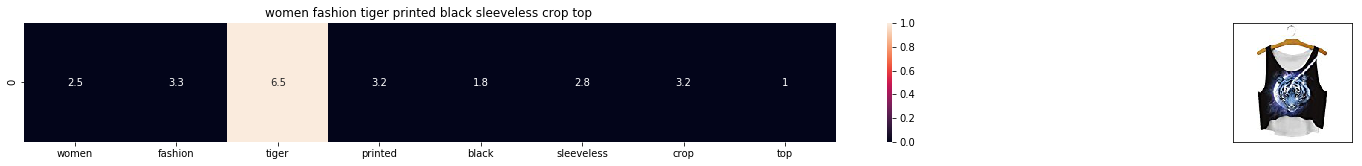

ASIN : B074T8ZYGX
Brand : MKP Crop Top
euclidean distance from the given image : 17.0808129556


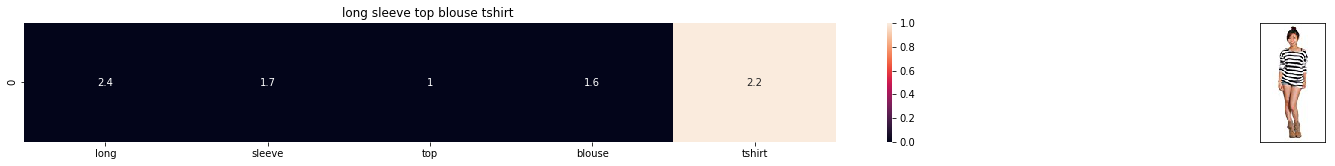

ASIN : B00KF2N5PU
Brand : Vietsbay
euclidean distance from the given image : 17.0901681256


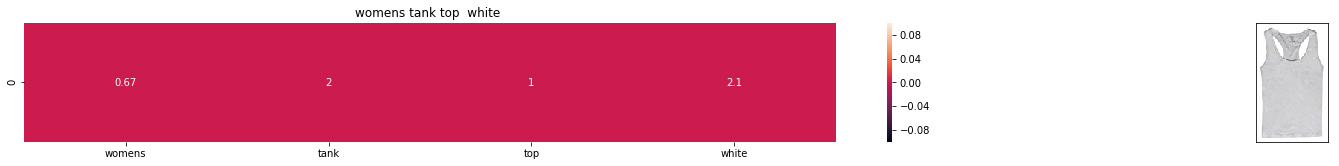

ASIN : B00JPOZ9GM
Brand : Sofra
euclidean distance from the given image : 17.1532153376


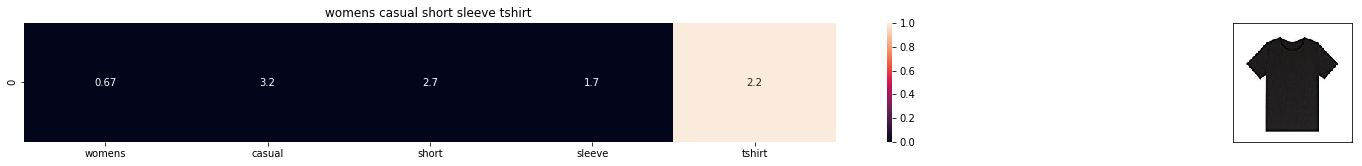

ASIN : B074T9KG9Q
Brand : Rain
euclidean distance from the given image : 17.3367152387


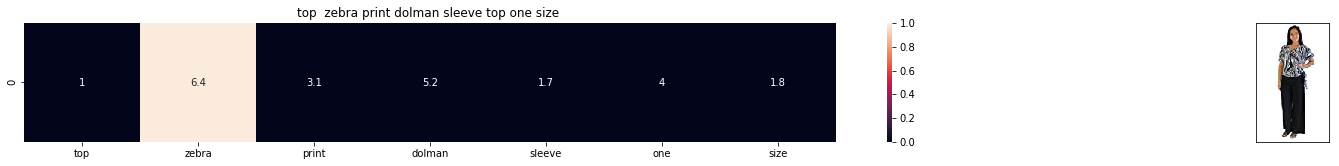

ASIN : B00H8A6ZLI
Brand : Vivian's Fashions
euclidean distance from the given image : 17.410075941


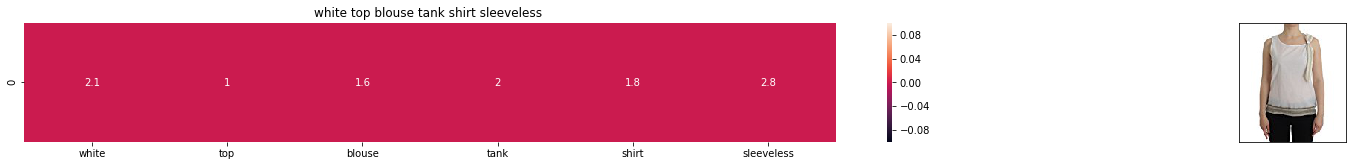

ASIN : B074G5G5RK
Brand : ERMANNO SCERVINO
euclidean distance from the given image : 17.5399213355


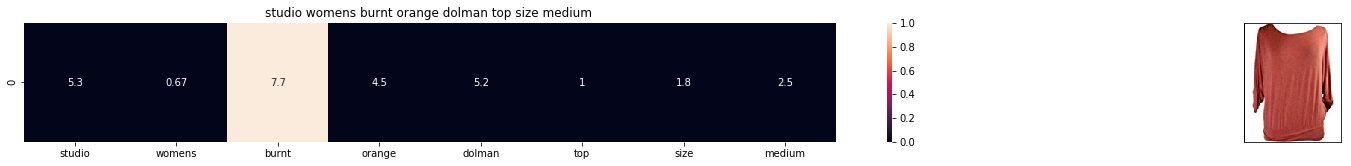

ASIN : B06XSCVFT5
Brand : Studio M
euclidean distance from the given image : 17.6127585437


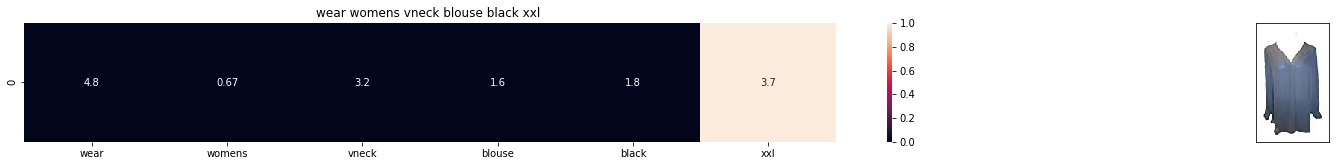

ASIN : B06Y6FH453
Brand : Who What Wear
euclidean distance from the given image : 17.6237452825


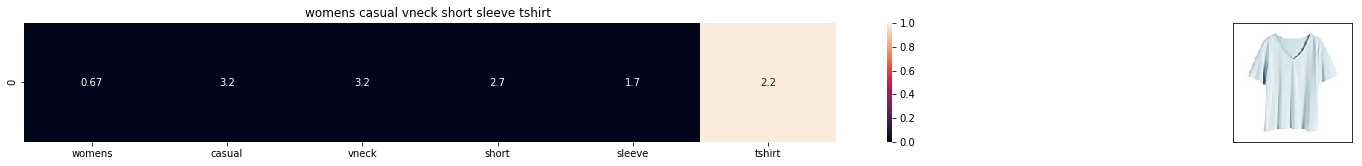

ASIN : B074V45DCX
Brand : Rain
euclidean distance from the given image : 17.6343424968


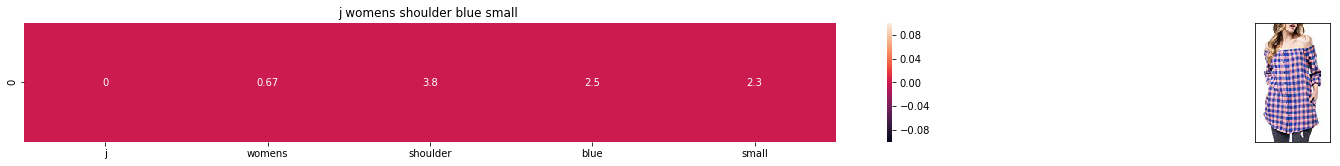

ASIN : B07583CQFT
Brand : Very J
euclidean distance from the given image : 17.6375371274


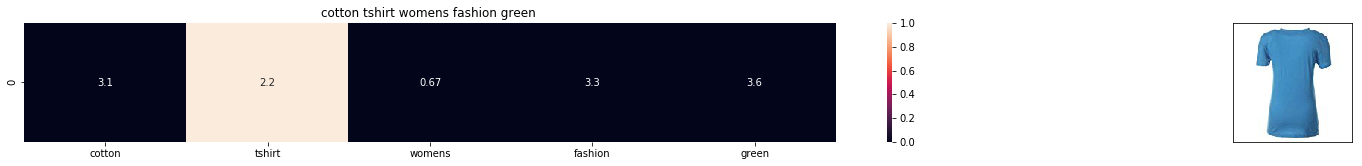

ASIN : B073GJGVBN
Brand : Ivan Levi
euclidean distance from the given image : 17.7230738913


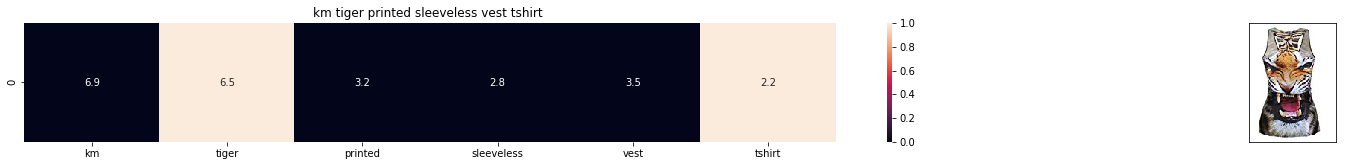

ASIN : B012VQLT6Y
Brand : KM T-shirt
euclidean distance from the given image : 17.7625885612


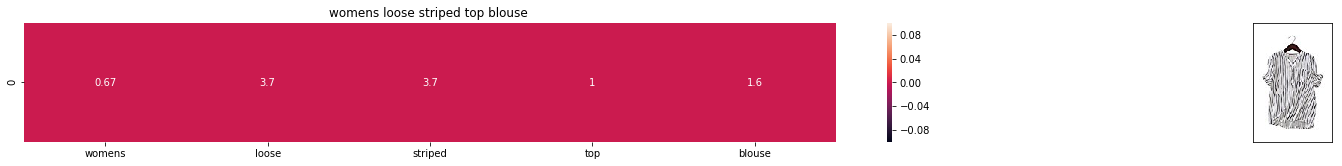

ASIN : B00ZZMYBRG
Brand : HP-LEISURE
euclidean distance from the given image : 17.7795368647


In [13]:
def idf_model(doc_id, num_results):
    # doc_id: apparel's id in given corpus
    
    # pairwise_dist will store the distance from given input apparel to all remaining apparels
    # the metric we used here is cosine, the coside distance is mesured as K(X, Y) = <X, Y> / (||X||*||Y||)
    # http://scikit-learn.org/stable/modules/metrics.html#cosine-similarity
    pairwise_dist = pairwise_distances(idf_title_features,idf_title_features[doc_id])

    # np.argsort will return indices of 9 smallest distances
    indices = np.argsort(pairwise_dist.flatten())[0:num_results]
    #pdists will store the 9 smallest distances
    pdists  = np.sort(pairwise_dist.flatten())[0:num_results]

    #data frame indices of the 9 smallest distace's
    df_indices = list(data.index[indices])

    for i in range(0,len(indices)):
        get_result(indices[i],data['title'].loc[df_indices[0]], data['title'].loc[df_indices[i]], data['medium_image_url'].loc[df_indices[i]], 'idf')
        print('ASIN :',data['asin'].loc[df_indices[i]])
        print('Brand :',data['brand'].loc[df_indices[i]])
        print ('euclidean distance from the given image :', pdists[i])
        print('='*125)

        
        
idf_model(12566,20)
# in the output heat map each value represents the idf values of the label word, the color represents the intersection with inputs title

In [14]:
import pickle
with open('word2vec_model', 'rb') as handle:
    model = pickle.load(handle)

In [15]:
def get_word_vec(sentence, doc_id, m_name):
    # sentence : title of the apparel
    # doc_id: document id in our corpus
    # m_name: model information it will take two values
        # if  m_name == 'avg', we will append the model[i], w2v representation of word i
        # if m_name == 'weighted', we will multiply each w2v[word] with the idf(word)
    vec = []
    for i in sentence.split():
        if i in vocab:
            if m_name == 'weighted' and i in  idf_title_vectorizer.vocabulary_:
                vec.append(idf_title_features[doc_id, idf_title_vectorizer.vocabulary_[i]] * model[i])
            elif m_name == 'avg':
                vec.append(model[i])
        else:
            # if the word in our courpus is not there in the google word2vec corpus, we are just ignoring it
            vec.append(np.zeros(shape=(300,)))
    # we will return a numpy array of shape (#number of words in title * 300 ) 300 = len(w2v_model[word])
    # each row represents the word2vec representation of each word (weighted/avg) in given sentance 
    return  np.array(vec)

In [16]:
def get_distance(vec1, vec2):
    # vec1 = np.array(#number_of_words_title1 * 300), each row is a vector of length 300 corresponds to each word in give title
    # vec2 = np.array(#number_of_words_title2 * 300), each row is a vector of length 300 corresponds to each word in give title
    
    final_dist = []
    # for each vector in vec1 we caluclate the distance(euclidean) to all vectors in vec2
    for i in vec1:
        dist = []
        for j in vec2:
            # np.linalg.norm(i-j) will result the euclidean distance between vectors i, j
            dist.append(np.linalg.norm(i-j))
        final_dist.append(np.array(dist))
    # final_dist = np.array(#number of words in title1 * #number of words in title2)
    # final_dist[i,j] = euclidean distance between vectors i, j
    return np.array(final_dist)

In [17]:
def heat_map_w2v(sentence1, sentence2, url, doc_id1, doc_id2, model):
    # sentance1 : title1, input apparel
    # sentance2 : title2, recommended apparel
    # url: apparel image url
    # doc_id1: document id of input apparel
    # doc_id2: document id of recommended apparel
    # model: it can have two values, 1. avg 2. weighted
    
    #s1_vec = np.array(#number_of_words_title1 * 300), each row is a vector(weighted/avg) of length 300 corresponds to each word in give title
    s1_vec = get_word_vec(sentence1, doc_id1, model)
    #s2_vec = np.array(#number_of_words_title1 * 300), each row is a vector(weighted/avg) of length 300 corresponds to each word in give title
    s2_vec = get_word_vec(sentence2, doc_id2, model)

    # s1_s2_dist = np.array(#number of words in title1 * #number of words in title2)
    # s1_s2_dist[i,j] = euclidean distance between words i, j
    s1_s2_dist = get_distance(s1_vec, s2_vec)

    
    
    # devide whole figure into 2 parts 1st part displays heatmap 2nd part displays image of apparel
    gs = gridspec.GridSpec(2, 2, width_ratios=[4,1],height_ratios=[2,1]) 
    fig = plt.figure(figsize=(15,15))
    
    ax = plt.subplot(gs[0])
    # ploting the heap map based on the pairwise distances
    ax = sns.heatmap(np.round(s1_s2_dist,4), annot=True)
    # set the x axis labels as recommended apparels title
    ax.set_xticklabels(sentence2.split())
    # set the y axis labels as input apparels title
    ax.set_yticklabels(sentence1.split())
    # set title as recommended apparels title
    ax.set_title(sentence2)
    
    ax = plt.subplot(gs[1])
    # we remove all grids and axis labels for image
    ax.grid(False)
    ax.set_xticks([])
    ax.set_yticks([])
    display_img(url, ax, fig)
    
    plt.show()

In [18]:
# vocab = stores all the words that are there in google w2v model
# vocab = model.wv.vocab.keys() # if you are using Google word2Vec

vocab = model.keys()
# this function will add the vectors of each word and returns the avg vector of given sentance
def build_avg_vec(sentence, num_features, doc_id, m_name):
    # sentace: its title of the apparel
    # num_features: the lenght of word2vec vector, its values = 300
    # m_name: model information it will take two values
        # if  m_name == 'avg', we will append the model[i], w2v representation of word i
        # if m_name == 'weighted', we will multiply each w2v[word] with the idf(word)

    featureVec = np.zeros((num_features,), dtype="float32")
    # we will intialize a vector of size 300 with all zeros
    # we add each word2vec(wordi) to this fetureVec
    nwords = 0
    
    for word in sentence.split():
        nwords += 1
        if word in vocab:
            if m_name == 'weighted' and word in  idf_title_vectorizer.vocabulary_:
                featureVec = np.add(featureVec, idf_title_features[doc_id, idf_title_vectorizer.vocabulary_[word]] * model[word])
            elif m_name == 'avg':
                featureVec = np.add(featureVec, model[word])
    if(nwords>0):
        featureVec = np.divide(featureVec, nwords)
    # returns the avg vector of given sentance, its of shape (1, 300)
    return featureVec

In [19]:
doc_id = 0
w2v_title_weight = []
# for every title we build a weighted vector representation
for i in data['title']:
    w2v_title_weight.append(build_avg_vec(i, 300, doc_id,'weighted'))
    doc_id += 1
# w2v_title = np.array(# number of doc in courpus * 300), each row corresponds to a doc 
w2v_title_weight = np.array(w2v_title_weight)

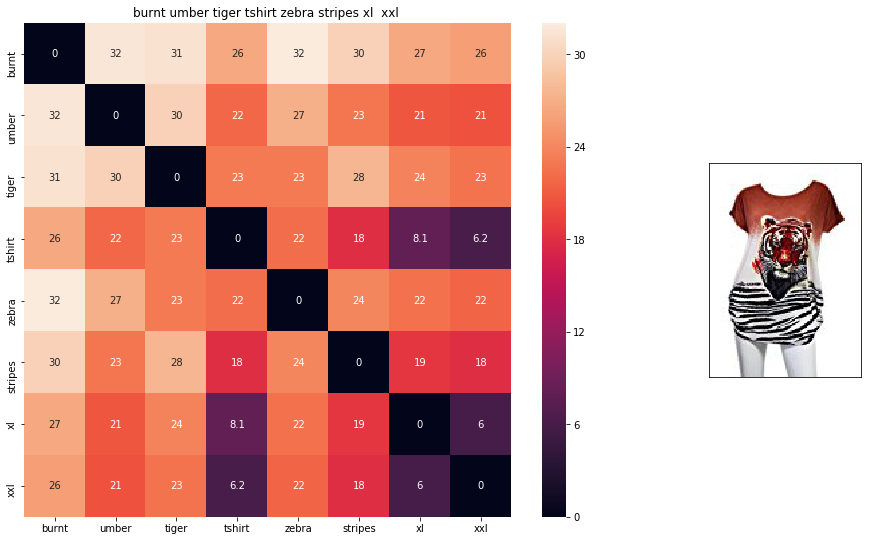

ASIN : B00JXQB5FQ
Brand : Si Row
euclidean distance from input : 0.00390625


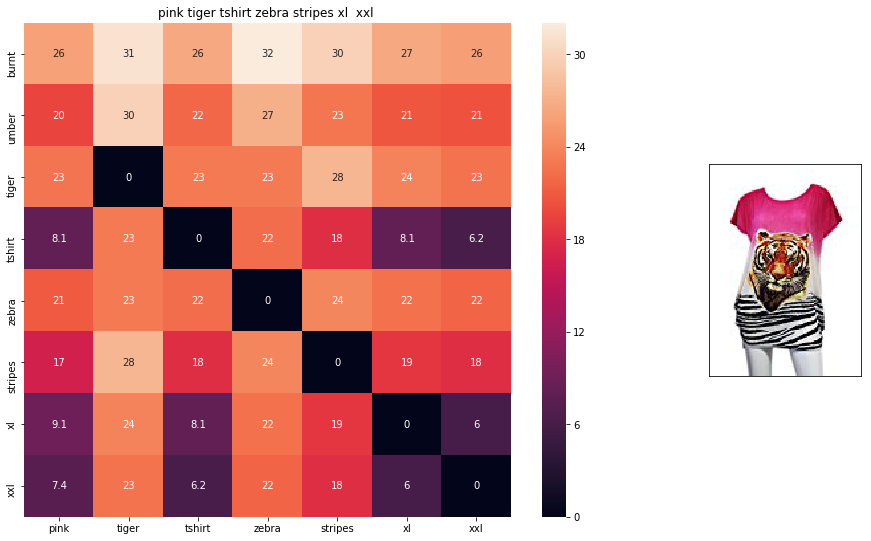

ASIN : B00JXQASS6
Brand : Si Row
euclidean distance from input : 4.06389


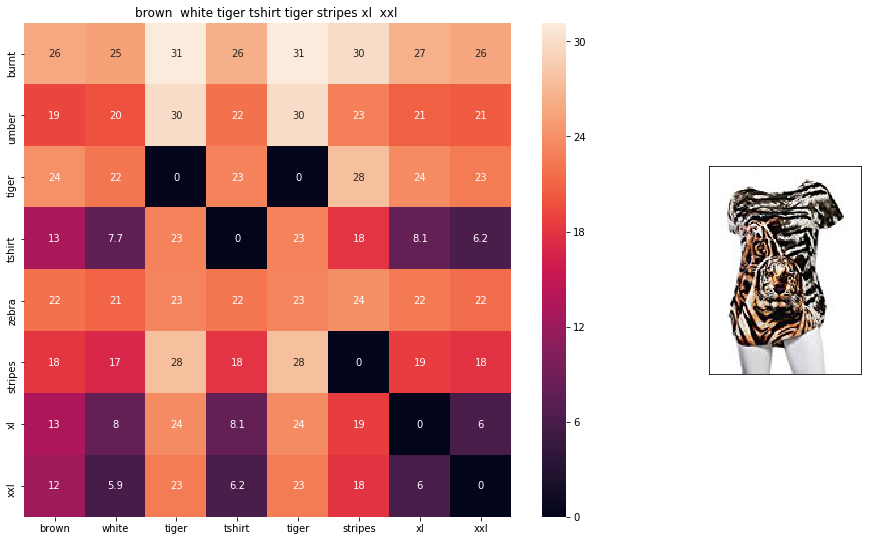

ASIN : B00JXQCWTO
Brand : Si Row
euclidean distance from input : 4.77094


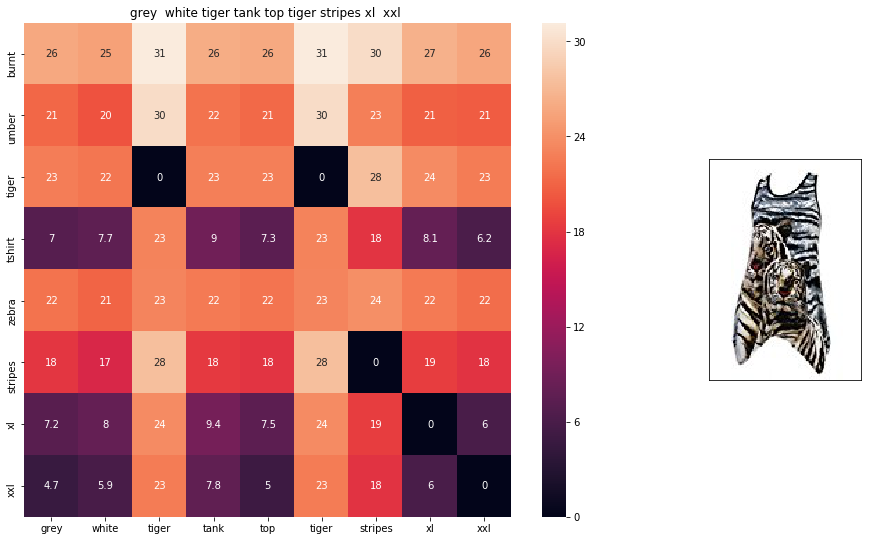

ASIN : B00JXQAFZ2
Brand : Si Row
euclidean distance from input : 5.36016


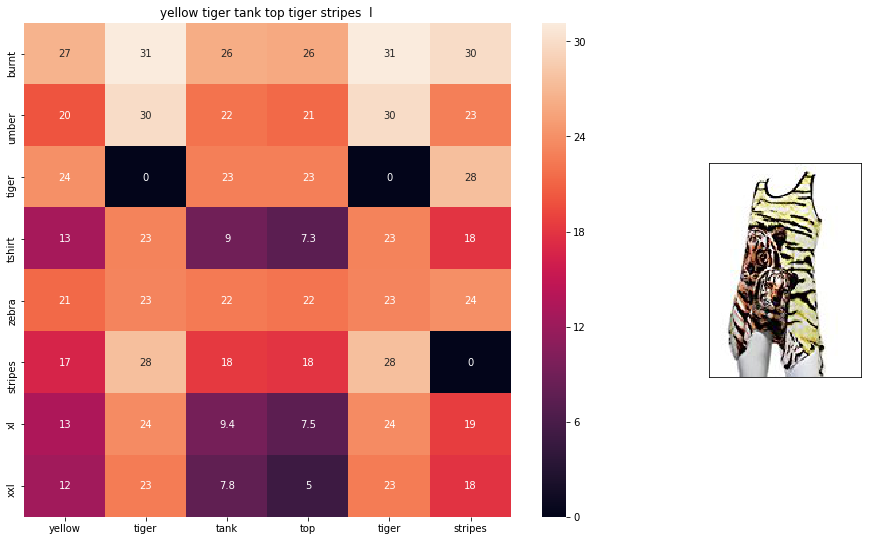

ASIN : B00JXQAUWA
Brand : Si Row
euclidean distance from input : 5.68952


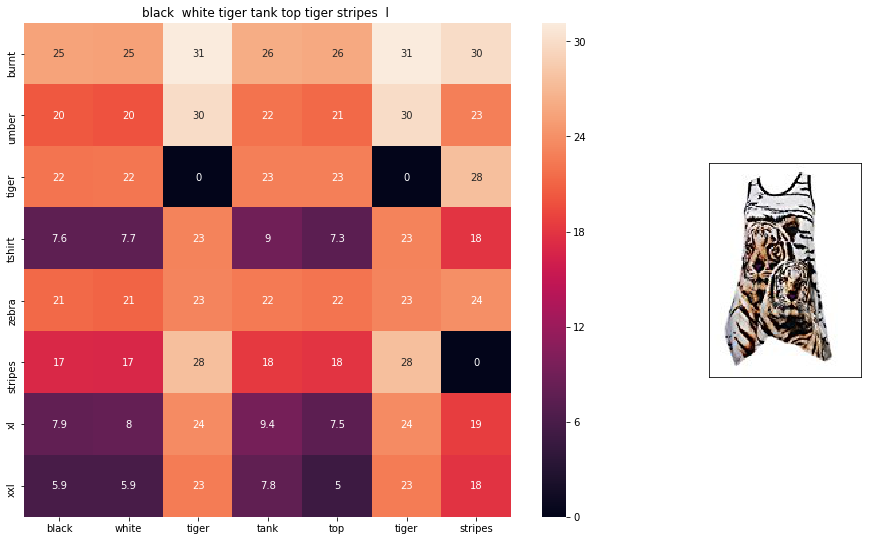

ASIN : B00JXQAO94
Brand : Si Row
euclidean distance from input : 5.69302


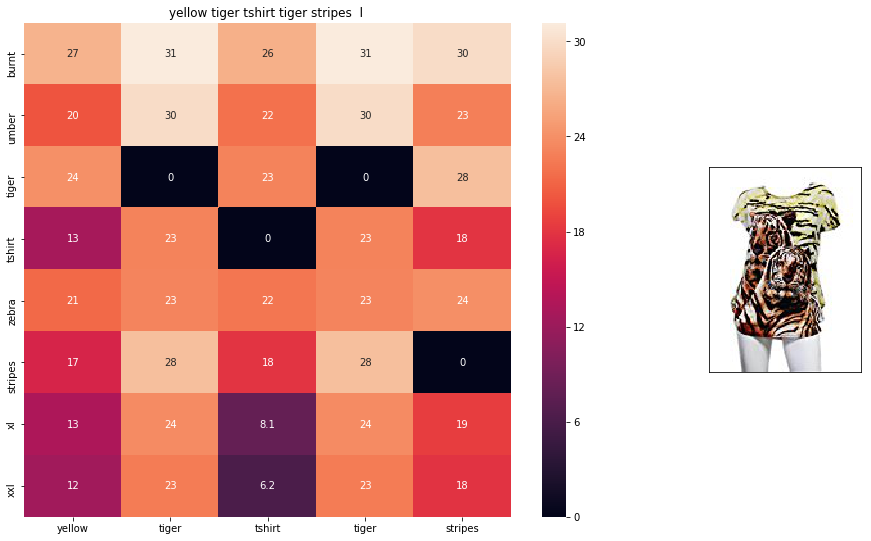

ASIN : B00JXQCUIC
Brand : Si Row
euclidean distance from input : 5.89344


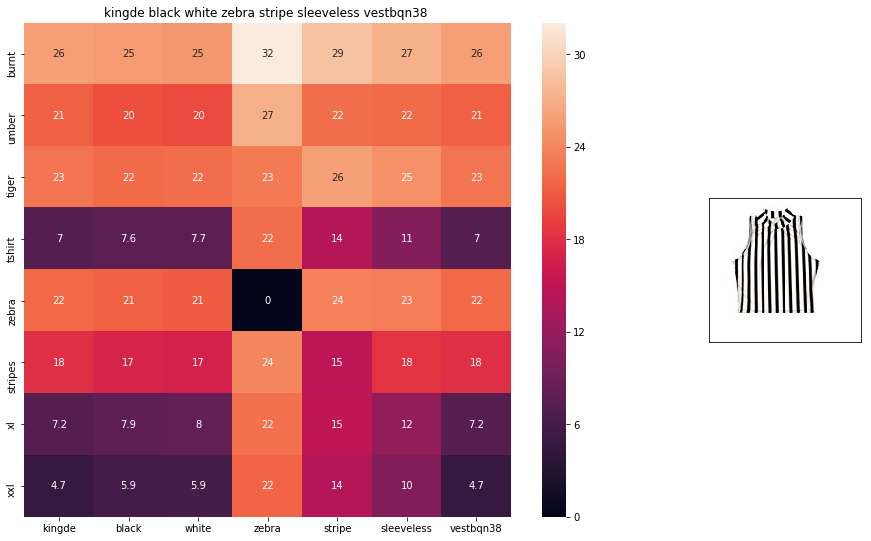

ASIN : B015H41F6G
Brand : KINGDE
euclidean distance from input : 6.13299


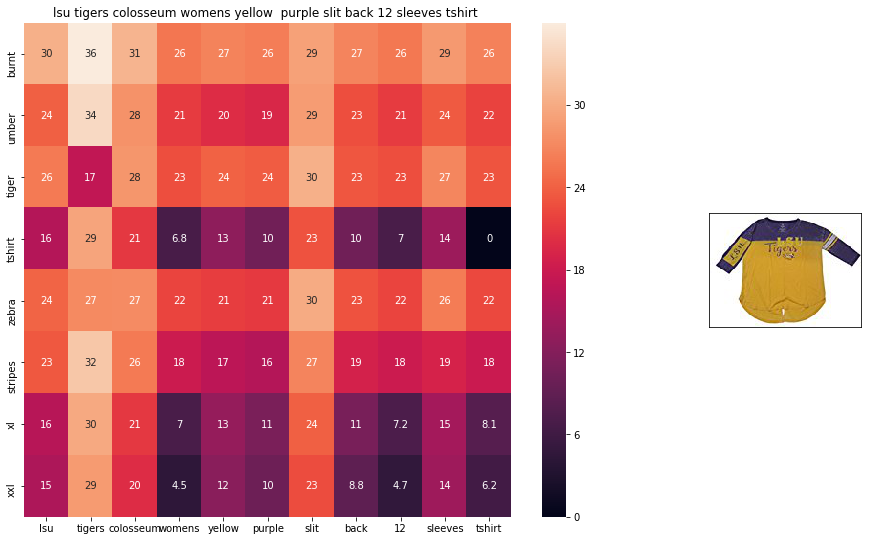

ASIN : B073R5Q8HD
Brand : Colosseum
euclidean distance from input : 6.25671


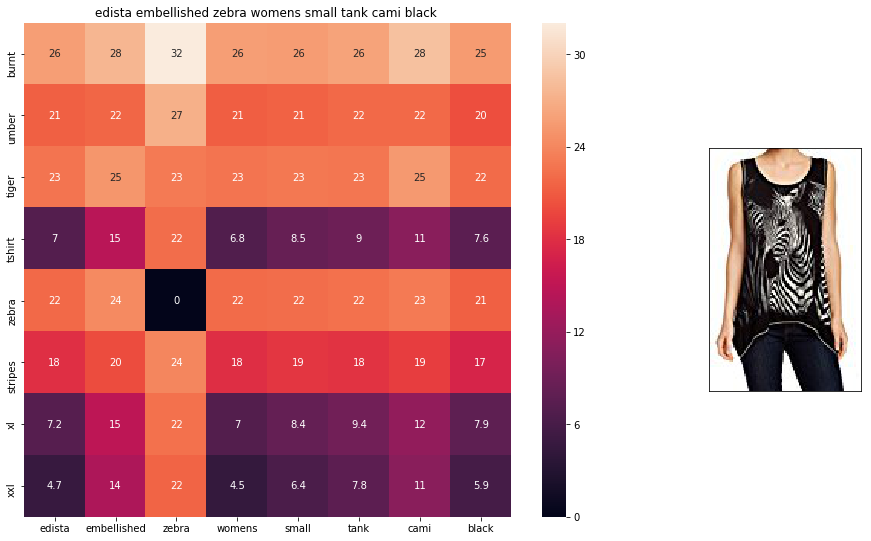

ASIN : B074P8MD22
Brand : Edista
euclidean distance from input : 6.3922


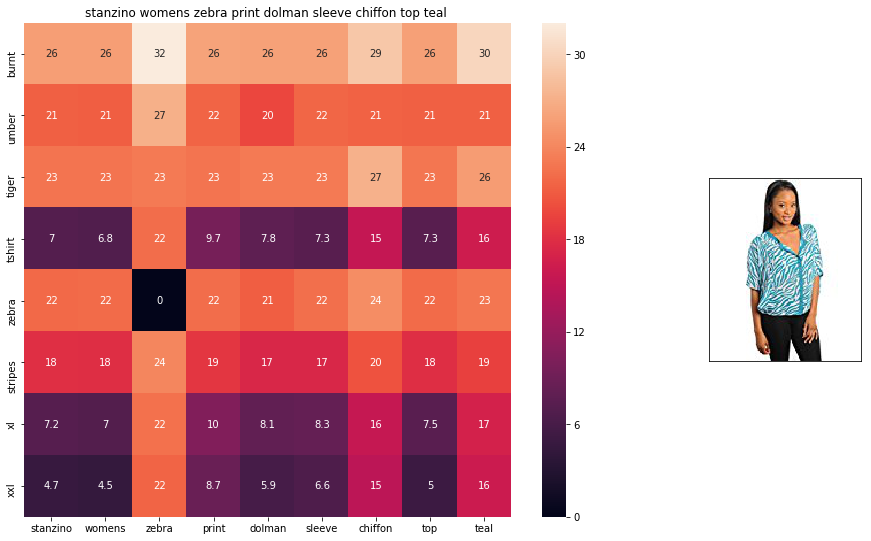

ASIN : B00C0I3U3E
Brand : Stanzino
euclidean distance from input : 6.4149


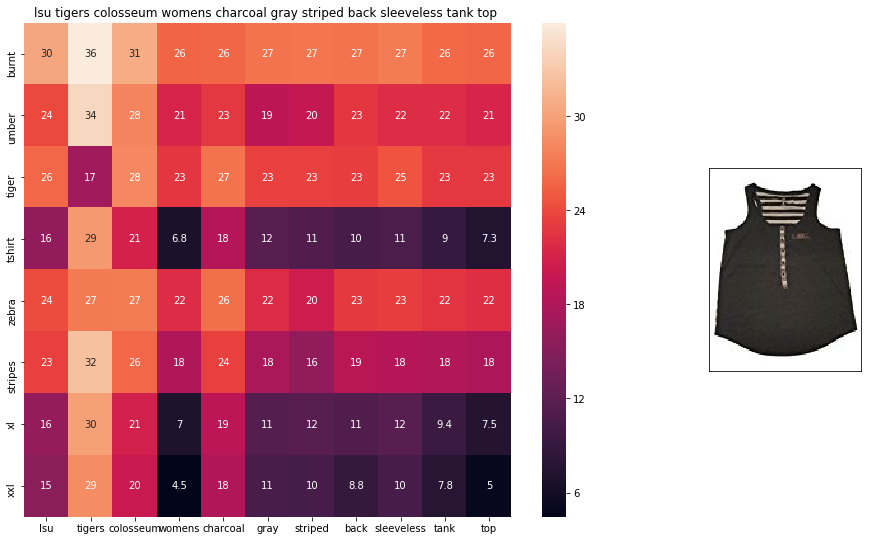

ASIN : B073R4ZM7Y
Brand : Colosseum
euclidean distance from input : 6.45096


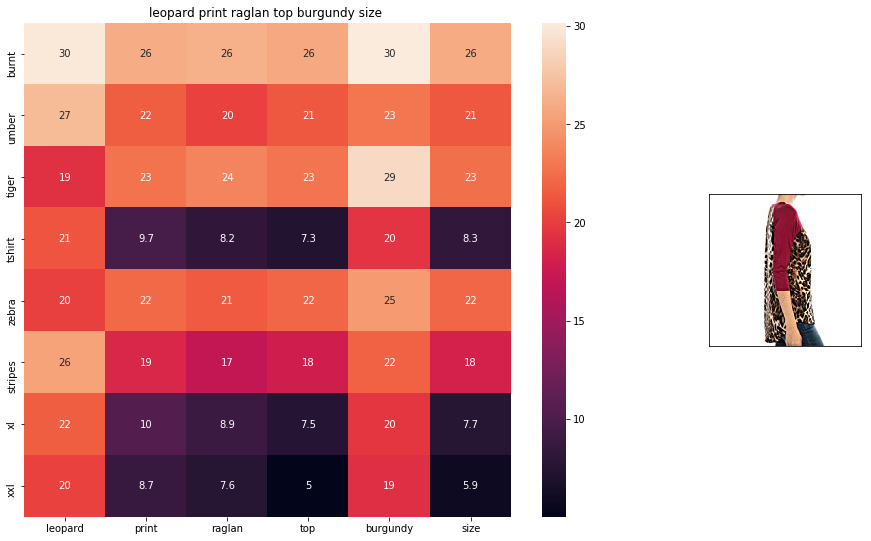

ASIN : B01C6ORLDQ
Brand : 1 Mad Fit
euclidean distance from input : 6.46341


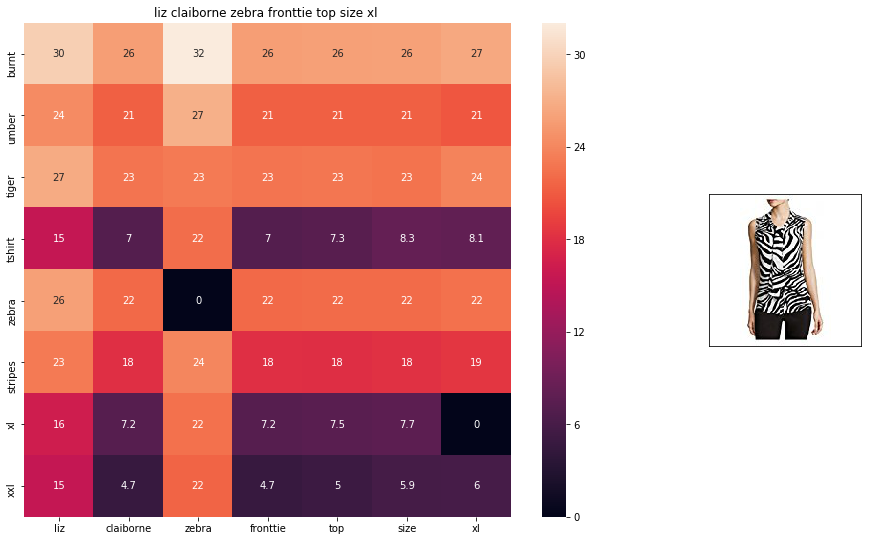

ASIN : B06XBY5QXL
Brand : Liz Claiborne
euclidean distance from input : 6.53922


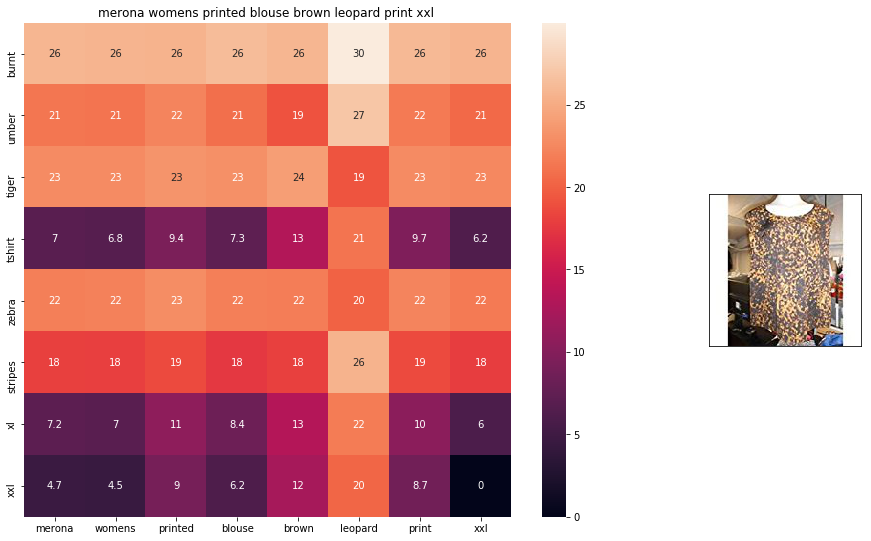

ASIN : B071YF3WDD
Brand : Merona
euclidean distance from input : 6.5755


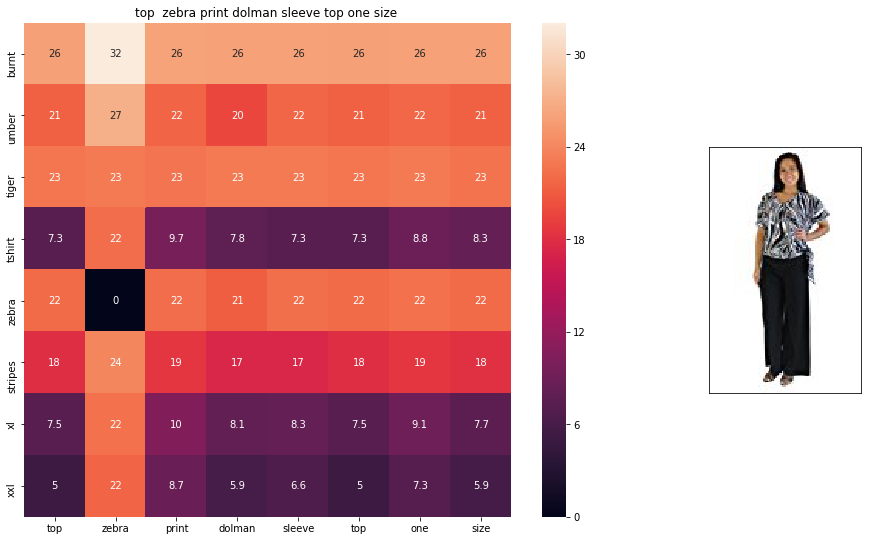

ASIN : B00H8A6ZLI
Brand : Vivian's Fashions
euclidean distance from input : 6.63822


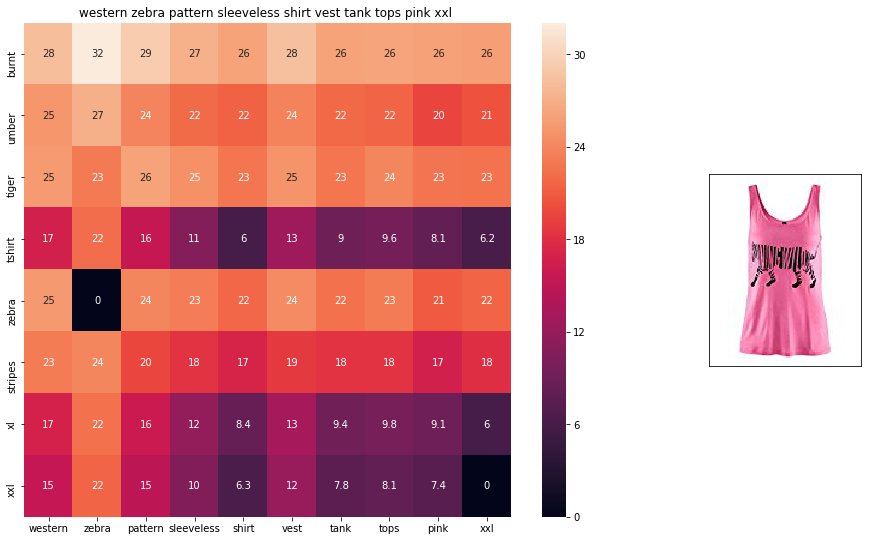

ASIN : B00Z6HEXWI
Brand : Black Temptation
euclidean distance from input : 6.66074


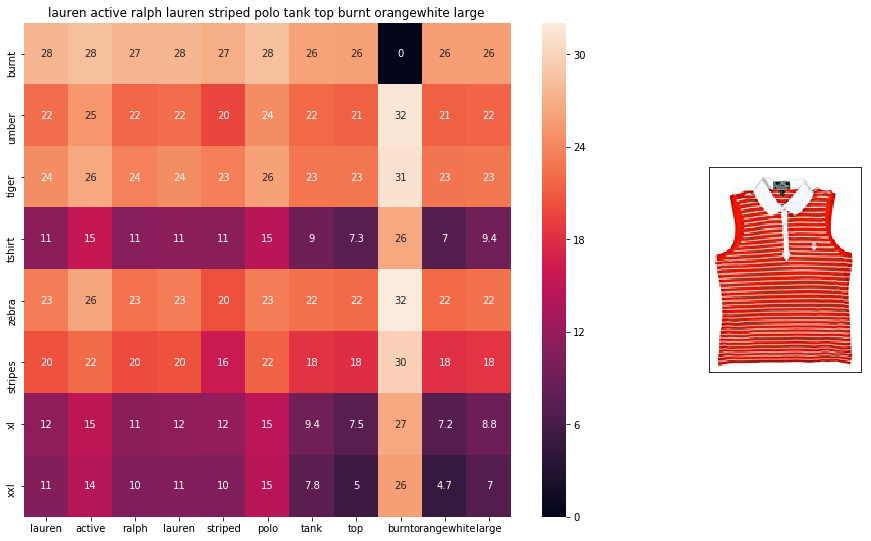

ASIN : B00ILGH5OY
Brand : Ralph Lauren Active
euclidean distance from input : 6.68391


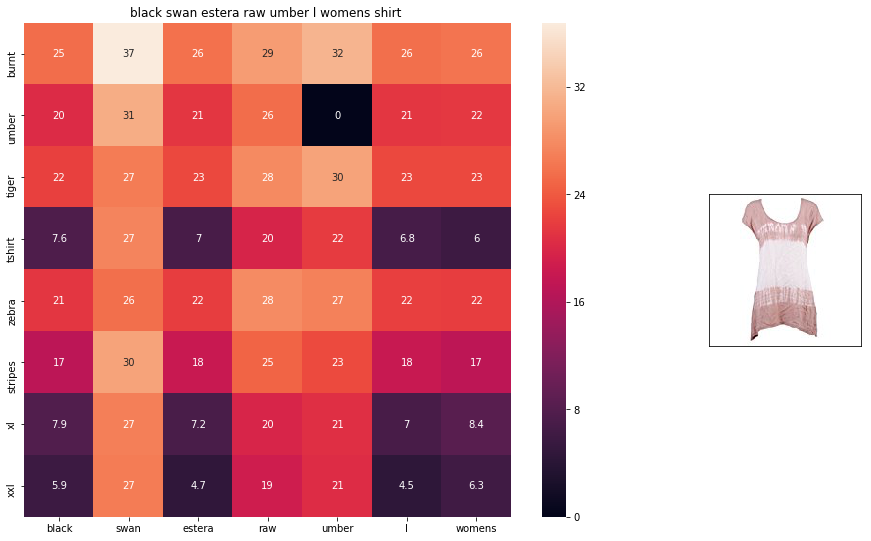

ASIN : B06Y1VN8WQ
Brand : Black Swan
euclidean distance from input : 6.70576


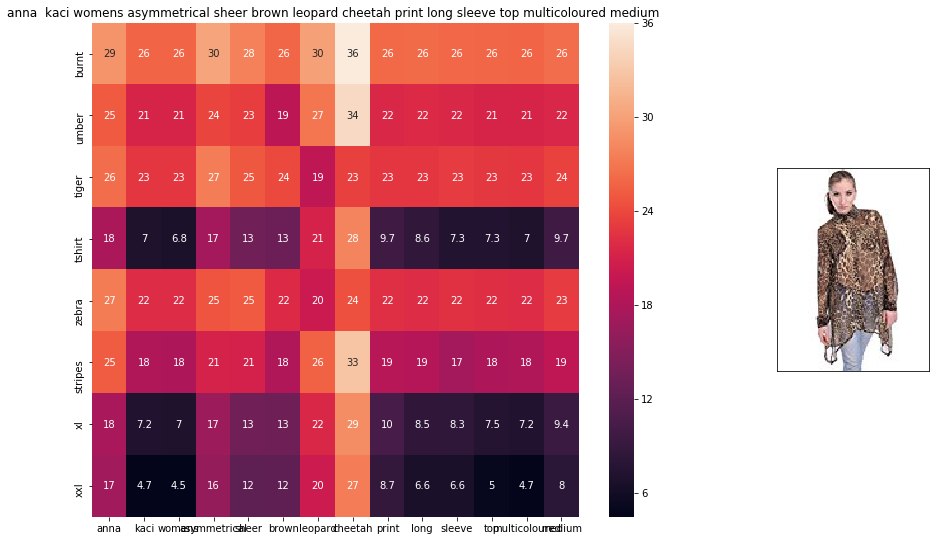

ASIN : B00KSNTY7Y
Brand : Anna-Kaci
euclidean distance from input : 6.70612


In [20]:
def weighted_w2v_model(doc_id, num_results):
    # doc_id: apparel's id in given corpus
    
    # pairwise_dist will store the distance from given input apparel to all remaining apparels
    # the metric we used here is cosine, the coside distance is mesured as K(X, Y) = <X, Y> / (||X||*||Y||)
    # http://scikit-learn.org/stable/modules/metrics.html#cosine-similarity
    pairwise_dist = pairwise_distances(w2v_title_weight, w2v_title_weight[doc_id].reshape(1,-1))

    # np.argsort will return indices of 9 smallest distances
    indices = np.argsort(pairwise_dist.flatten())[0:num_results]
    #pdists will store the 9 smallest distances
    pdists  = np.sort(pairwise_dist.flatten())[0:num_results]

    #data frame indices of the 9 smallest distace's
    df_indices = list(data.index[indices])
    
    for i in range(0, len(indices)):
        heat_map_w2v(data['title'].loc[df_indices[0]],data['title'].loc[df_indices[i]], data['medium_image_url'].loc[df_indices[i]], indices[0], indices[i], 'weighted')
        print('ASIN :',data['asin'].loc[df_indices[i]])
        print('Brand :',data['brand'].loc[df_indices[i]])
        print('euclidean distance from input :', pdists[i])
        print('='*125)

weighted_w2v_model(12566, 20)
#931
#12566
# in the give heat map, each cell contains the euclidean distance between words i, j

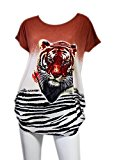

Product Title:  burnt umber tiger tshirt zebra stripes xl  xxl 
Euclidean Distance from input image: 0.0625
Amazon Url: www.amzon.com/dp/B00JXQB5FQ


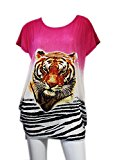

Product Title:  pink tiger tshirt zebra stripes xl  xxl 
Euclidean Distance from input image: 30.0501
Amazon Url: www.amzon.com/dp/B00JXQASS6


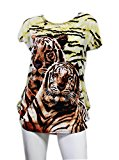

Product Title:  yellow tiger tshirt tiger stripes  l 
Euclidean Distance from input image: 41.2611
Amazon Url: www.amzon.com/dp/B00JXQCUIC


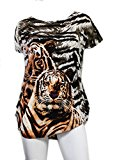

Product Title:  brown  white tiger tshirt tiger stripes xl  xxl 
Euclidean Distance from input image: 44.0002
Amazon Url: www.amzon.com/dp/B00JXQCWTO


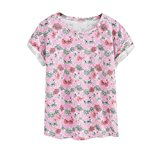

Product Title:  kawaii pastel tops tees pink flower design 
Euclidean Distance from input image: 47.3825
Amazon Url: www.amzon.com/dp/B071FCWD97


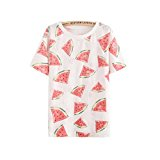

Product Title:  womens thin style tops tees pastel watermelon print 
Euclidean Distance from input image: 47.7184
Amazon Url: www.amzon.com/dp/B01JUNHBRM


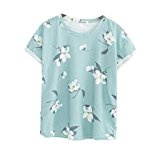

Product Title:  kawaii pastel tops tees baby blue flower design 
Euclidean Distance from input image: 47.9021
Amazon Url: www.amzon.com/dp/B071SBCY9W


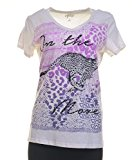

Product Title:  edv cheetah run purple multi xl 
Euclidean Distance from input image: 48.0465
Amazon Url: www.amzon.com/dp/B01CUPYBM0


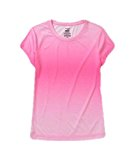

Product Title:  danskin womens vneck loose performance tee xsmall pink ombre 
Euclidean Distance from input image: 48.1019
Amazon Url: www.amzon.com/dp/B01F7PHXY8


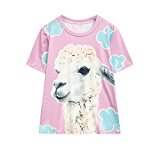

Product Title:  summer alpaca 3d pastel casual loose tops tee design 
Euclidean Distance from input image: 48.1189
Amazon Url: www.amzon.com/dp/B01I80A93G


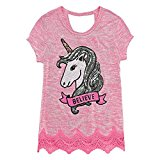

Product Title:  miss chievous juniors striped peplum tank top medium shadowpeach 
Euclidean Distance from input image: 48.1313
Amazon Url: www.amzon.com/dp/B0177DM70S


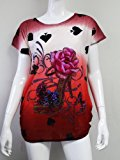

Product Title:  red  pink floral heel sleeveless shirt xl  xxl 
Euclidean Distance from input image: 48.1695
Amazon Url: www.amzon.com/dp/B00JV63QQE


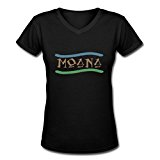

Product Title:  moana logo adults hot v neck shirt black xxl 
Euclidean Distance from input image: 48.2568
Amazon Url: www.amzon.com/dp/B01LX6H43D


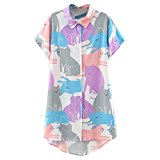

Product Title:  abaday multicolor cartoon cat print short sleeve longline shirt large 
Euclidean Distance from input image: 48.2656
Amazon Url: www.amzon.com/dp/B01CR57YY0


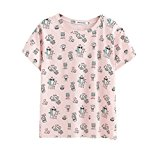

Product Title:  kawaii cotton pastel tops tees peach pink cactus design 
Euclidean Distance from input image: 48.3626
Amazon Url: www.amzon.com/dp/B071WYLBZS


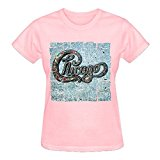

Product Title:  chicago chicago 18 shirt women pink 
Euclidean Distance from input image: 48.3836
Amazon Url: www.amzon.com/dp/B01GXAZTRY


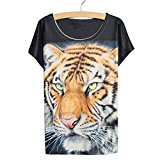

Product Title:  yichun womens tiger printed summer tshirts tops 
Euclidean Distance from input image: 48.4493
Amazon Url: www.amzon.com/dp/B010NN9RXO


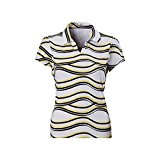

Product Title:  nancy lopez whimsy short sleeve  whiteblacklemon drop  xs 
Euclidean Distance from input image: 48.4789
Amazon Url: www.amzon.com/dp/B01MPX6IDX


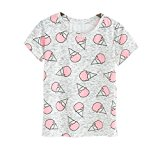

Product Title:  womens tops tees pastel peach ice cream cone print 
Euclidean Distance from input image: 48.558
Amazon Url: www.amzon.com/dp/B0734GRKZL


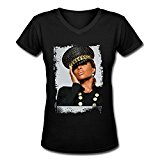

Product Title:  uswomens mary j blige without tshirts shirt 
Euclidean Distance from input image: 48.6144
Amazon Url: www.amzon.com/dp/B01M0XXFKK


In [21]:
#load the features and corresponding ASINS info.
bottleneck_features_train = np.load('16k_data_cnn_features.npy')
asins = np.load('16k_data_cnn_feature_asins.npy')
asins = list(asins)

# load the original 16K dataset
data = pd.read_pickle('pickels/16k_apperal_data_preprocessed')
df_asins = list(data['asin'])

###



###


from IPython.display import display, Image, SVG, Math, YouTubeVideo


#get similar products using CNN features (VGG-16)
def get_similar_products_cnn(doc_id, num_results):
    doc_id = asins.index(df_asins[doc_id])
    pairwise_dist = pairwise_distances(bottleneck_features_train, bottleneck_features_train[doc_id].reshape(1,-1))

    indices = np.argsort(pairwise_dist.flatten())[0:num_results]
    pdists  = np.sort(pairwise_dist.flatten())[0:num_results]

    for i in range(len(indices)):
        rows = data[['medium_image_url','title']].loc[data['asin']==asins[indices[i]]]
        for indx, row in rows.iterrows():
            display(Image(url=row['medium_image_url'], embed=True))
            print('Product Title: ', row['title'])
            print('Euclidean Distance from input image:', pdists[i])
            print('Amazon Url: www.amzon.com/dp/'+ asins[indices[i]])

get_similar_products_cnn(12566, 20)

In [22]:
# some of the brand values are empty. 
# Need to replace Null with string "NULL"
data['brand'].fillna(value="Not given", inplace=True )

# replace spaces with hypen
brands = [x.replace(" ", "-") for x in data['brand'].values]
types = [x.replace(" ", "-") for x in data['product_type_name'].values]
colors = [x.replace(" ", "-") for x in data['color'].values]

brand_vectorizer = CountVectorizer()
brand_features = brand_vectorizer.fit_transform(brands)

type_vectorizer = CountVectorizer()
type_features = type_vectorizer.fit_transform(types)

color_vectorizer = CountVectorizer()
color_features = color_vectorizer.fit_transform(colors)

extra_features = hstack((brand_features, type_features, color_features)).tocsr()

In [23]:
def heat_map_w2v_brand(sentance1, sentance2, url, doc_id1, doc_id2, df_id1, df_id2, model):
    
    # sentance1 : title1, input apparel
    # sentance2 : title2, recommended apparel
    # url: apparel image url
    # doc_id1: document id of input apparel
    # doc_id2: document id of recommended apparel
    # df_id1: index of document1 in the data frame
    # df_id2: index of document2 in the data frame
    # model: it can have two values, 1. avg 2. weighted
    
    #s1_vec = np.array(#number_of_words_title1 * 300), each row is a vector(weighted/avg) of length 300 corresponds to each word in give title
    s1_vec = get_word_vec(sentance1, doc_id1, model)
    #s2_vec = np.array(#number_of_words_title2 * 300), each row is a vector(weighted/avg) of length 300 corresponds to each word in give title
    s2_vec = get_word_vec(sentance2, doc_id2, model)
    
    # s1_s2_dist = np.array(#number of words in title1 * #number of words in title2)
    # s1_s2_dist[i,j] = euclidean distance between words i, j
    s1_s2_dist = get_distance(s1_vec, s2_vec)
   
    data_matrix = [['Asin','Brand', 'Color', 'Product type'],
               [data['asin'].loc[df_id1],brands[doc_id1], colors[doc_id1], types[doc_id1]], # input apparel's features
               [data['asin'].loc[df_id2],brands[doc_id2], colors[doc_id2], types[doc_id2]]] # recommonded apparel's features
    
    colorscale = [[0, '#1d004d'],[.5, '#f2e5ff'],[1, '#f2e5d1']] # to color the headings of each column 
    
    # we create a table with the data_matrix
    table = ff.create_table(data_matrix, index=True, colorscale=colorscale)
    # plot it with plotly
    plotly.offline.iplot(table, filename='simple_table')
    
    # devide whole figure space into 25 * 1:10 grids
    gs = gridspec.GridSpec(25, 15)
    fig = plt.figure(figsize=(25,5))
    
    # in first 25*10 grids we plot heatmap
    ax1 = plt.subplot(gs[:, :-5])
    # ploting the heap map based on the pairwise distances
    ax1 = sns.heatmap(np.round(s1_s2_dist,6), annot=True)
    # set the x axis labels as recommended apparels title
    ax1.set_xticklabels(sentance2.split())
    # set the y axis labels as input apparels title
    ax1.set_yticklabels(sentance1.split())
    # set title as recommended apparels title
    ax1.set_title(sentance2)

    # in last 25 * 10:15 grids we display image
    ax2 = plt.subplot(gs[:, 10:16])
    # we dont display grid lins and axis labels to images
    ax2.grid(False)
    ax2.set_xticks([])
    ax2.set_yticks([])
    
    # pass the url it display it
    display_img(url, ax2, fig)
    
    plt.show()

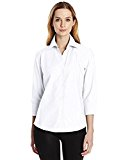

ASIN : B00JXQB5FQ
Brand : Si Row
euclidean distance from input : 0.0230736494064


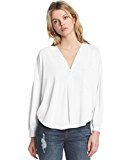

ASIN : B06XBHNM7J
Brand : Xhilaration
euclidean distance from input : 21.2839014055


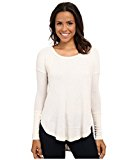

ASIN : B018H5AZXQ
Brand : Buffalo
euclidean distance from input : 22.3434160234


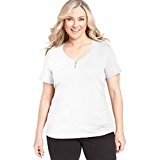

ASIN : B074MXY984
Brand : We The Free
euclidean distance from input : 22.5397306442


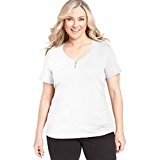

ASIN : B074LTBWSW
Brand : Liz Lange
euclidean distance from input : 22.5588193895


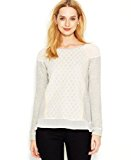

ASIN : B06XYP1X1F
Brand : J Brand Jeans
euclidean distance from input : 22.6142686033


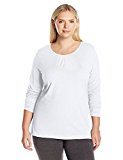

ASIN : B016CU40IY
Brand : Juiceclouds
euclidean distance from input : 22.8604555432


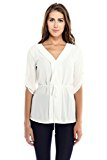

ASIN : B01BMSFYW2
Brand : igertommy hilf
euclidean distance from input : 22.8942307615


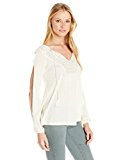

ASIN : B01L7ROZNC
Brand : Bila
euclidean distance from input : 23.0802231137


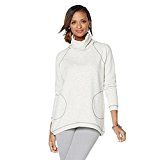

ASIN : B01FJVZST2
Brand : KONGYII
euclidean distance from input : 23.3456920926


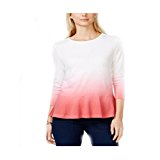

ASIN : B01EXXFS4M
Brand : No Boundaries
euclidean distance from input : 23.5959381105


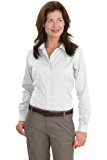

ASIN : B01L9F153U
Brand : ATYPEMX
euclidean distance from input : 23.6668615643


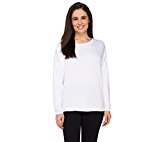

ASIN : B06Y41MRCH
Brand : Byoung
euclidean distance from input : 23.7053726198


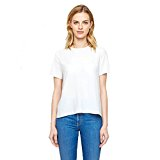

ASIN : B074MK6LV2
Brand : 1.State
euclidean distance from input : 23.7094412152


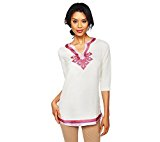

ASIN : B0756JTS1F
Brand : Salvatore Ferragamo
euclidean distance from input : 23.7288158417


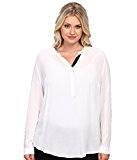

ASIN : B00DP4VHWI
Brand : Stanzino
euclidean distance from input : 23.7832344357


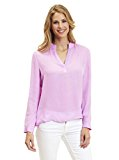

ASIN : B00JMAASRO
Brand : Wotefusi
euclidean distance from input : 23.8807531659


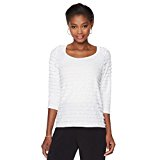

ASIN : B01DNNI1RO
Brand : Usstore
euclidean distance from input : 23.8886280062


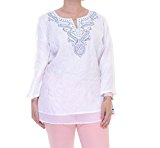

ASIN : B01G7XE50E
Brand : Merona
euclidean distance from input : 23.9667866055


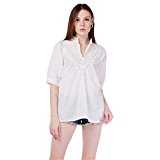

ASIN : B01M8GB3AL
Brand : Maven West
euclidean distance from input : 23.9822755815


In [27]:
def idf_w2v_brand_cnn(doc_id, w1, w2, w3, num_results):
    #doc_id: apparel's  id in given corpus
    #w1 : weight for w2v features
    #w2 : weight for brand and color features
    #w3 : weignt for CNN features
    # pairwise_dist will store the distance from given input apparel to all remaining apparels
    # the metric we used here is cosine, the coside distance is mesured as K(X, Y) = <X, Y> / (||X||*||Y||)
    # http://scikit-learn.org/stable/modules/metrics.html#cosine-similarity
    idf_w2v_dist  = pairwise_distances(w2v_title_weight, w2v_title_weight[doc_id].reshape(1,-1))
    cnn_dist = pairwise_distances(bottleneck_features_train, bottleneck_features_train[doc_id].reshape(1,-1))
    ex_feat_dist = pairwise_distances(extra_features, extra_features[doc_id])
    pairwise_dist   = (w1 * idf_w2v_dist +  w2 * ex_feat_dist + w3 * cnn_dist)/float(w1 + w2 +w3)

    # np.argsort will return indices of 9 smallest distances
    indices = np.argsort(pairwise_dist.flatten())[0:num_results]
    #pdists will store the 9 smallest distances
    pdists  = np.sort(pairwise_dist.flatten())[0:num_results]

    #data frame indices of the 9 smallest distace's
    df_indices = list(data.index[indices])
    

    for i in range(0, len(indices)):
        rows = data[['medium_image_url','title']].loc[data['asin']==asins[indices[i]]]
        for indx, row in rows.iterrows():
            display(Image(url=row['medium_image_url'], embed=True))
            #heat_map_w2v_brand(data['title'].loc[df_indices[0]],data['title'].loc[df_indices[i]], data['medium_image_url'].loc[df_indices[i]], indices[0], indices[i],df_indices[0], df_indices[i], 'weighted')
        
            print('ASIN :',data['asin'].loc[df_indices[i]])
            print('Brand :',data['brand'].loc[df_indices[i]])
            print('euclidean distance from input :', pdists[i])
            print('='*125)

idf_w2v_brand_cnn(12566, 5, 5, 10, 20)
# in the give heat map, each cell contains the euclidean distance between words i, j
    